# General Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
from pyomo.environ import *
from pyomo.environ import RangeSet
from pyomo.environ import value
import plotly.graph_objects as go

In [2]:
A_url = "https://raw.githubusercontent.com/FarshidNazemi/Plastic-Packaging/refs/heads/main/csv-files/A%20(USLCI)-Design.csv"
B_url = "https://raw.githubusercontent.com/FarshidNazemi/Plastic-Packaging/refs/heads/main/csv-files/B%20(USLCI)-Design.csv"
C_url = "https://raw.githubusercontent.com/FarshidNazemi/Plastic-Packaging/refs/heads/main/csv-files/C%20(USLCI)-Design.csv"

In [3]:
A_df_org = pd.read_csv(A_url,header=None)
B_df_org = pd.read_csv(B_url,header=None)
C_df_org = pd.read_csv(C_url,header=None)
C_df = C_df_org

In [4]:
A_df_org.to_csv('A_df_org.csv', index=False)
B_df_org.to_csv('B_df_org.csv', index=False)

### Removing Transportation from A and B

In [5]:
transport_processes = ['Transport, barge, average fuel mix',
                            'Transport, barge, diesel powered',
                            'Transport, barge, residual fuel oil powered',
                            'Transport, combination truck, average fuel mix',
                            'Transport, combination truck, diesel powered',
                            'Transport, ocean freighter, average fuel mix',
                            'Transport, ocean freighter, diesel powered',
                            'Transport, ocean freighter, residual fuel oil powered',
                            'Transport, pipeline, natural gas',
                            'Transport, pipeline, unspecified petroleum products',
                            'Transport, single unit truck, diesel powered',
                            'Transport, train, diesel powered']

In [6]:
#finding columns in A with transportation 
store_index_transport_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in transport_processes:
        stored_index_A = i
        store_index_transport_A_col.append(stored_index_A)

In [7]:
#finding columns in B with transportation
store_index_transport_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in transport_processes:
        stored_index_B = i
        store_index_transport_B.append(stored_index_B)

In [8]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_transport_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_transport_B], axis=1)

In [9]:
#Finding Transportation rows
store_index_transport_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in transport_processes:
        stored_index_A = i
        store_index_transport_A_row.append(stored_index_A)

In [10]:
#removing transportation rows from A
A_df_org = A_df_org.drop(A_df_org.columns[store_index_transport_A_row], axis=0)

In [11]:
A_df_org.to_csv('A_df_org_transport.csv', index=False)

# Base Case (Linear Economy)

## b:  Electricity generation UUIDs in USLCI

In [12]:
electricity_processes = ['Electrcity, solar photovoltatic',
                         'Electricity',
                         'Electricity, at cogen, for natural gas turbine',
                         'Electricity, at Grid, US, 2010',
                         'Electricity, biomass, at power plant',
                         'Electricity, bituminous coal, at power plant',
                         'Electricity, concentrated solar power (CSP)',
                         'Electricity, diesel, at power plant',
                         'Electricity, Eastern US, 2014',
                         'Electricity, lignite coal, at power plant',
                         'Electricity, natural gas, at power plant',
                         'Electricity, nuclear, at power plant',
                         'Electricity, residual fuel oil, at power plant',
                         'Electricity, solar'
                            ]

In [13]:
#finding columns in A with electricity generation
store_index_electricity_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_col.append(stored_index_A)

In [14]:
#finding rows in A with electricity generation
store_index_electricity_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_row.append(stored_index_A)

In [15]:
#finding columns in B with electricity generation
store_index_electricity_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in electricity_processes:
        stored_index_B = i
        store_index_electricity_B.append(stored_index_B)

### Removing corresponding electricity columns from A and B

In [16]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_electricity_B], axis=1)

### Aggregating all electricity flows in each process

In [17]:
electricity_sums = np.sum(np.array(A_df_org.loc[store_index_electricity_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float), axis=0)

In [18]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [19]:
A_df_org = A_df_org_tr.T

In [20]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [21]:
B_df_org = B_df_org_tr.T

### Removing electricity rows from A

In [22]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_row], axis=0)

### Add new electricity rows and columns

In [23]:
new_elec = [
        'Electricity',
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

new_elec_row = [
        'Electricity',
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

In [24]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_elec_df = pd.DataFrame(new_elec_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_elec_df], ignore_index=True)

In [25]:
# Append new columns in A
for elec in new_elec:
    A_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    A_df_org.at[0, elec] = elec  # Set the value in the first row

In [26]:
# Append new columns in B
for elec in new_elec:
    B_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    B_df_org.at[0, elec] = elec  # Set the value in the first row

In [27]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [28]:
A_df_org = A_df_org_tr.T

In [29]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [30]:
B_df_org = B_df_org_tr.T

In [31]:
A_df_org.reset_index(drop=True, inplace=True)

In [32]:
A_df_org.to_csv('A_df_org_electricity.csv', index=False)
B_df_org.to_csv('B_df_org_electricity.csv', index=False)

## Heat

In [33]:
heat_processes = [
    '73cd1596-214d-3403-87f1-f69fc3818886', #'Bituminous coal, combusted in industrial boiler',
    'e04995fa-935b-316c-b112-5b436c8ea3d6', #'Diesel, combusted in industrial boiler',
    'f6e5887d-644b-44ee-bb9d-5c2fd3d07b4a', #'Heat',
    '97624ce0-6d6a-3376-bfa7-c663b3c7e48d', #'Heat, onsite boiler, hardwood mill, average, SE',
    '833c3f72-fbbe-37ea-adf8-929b47ec0255', #'Heat, onsite boiler, hardwood mill, average, SE',
    'eb6394c1-0d19-3be3-99ab-ec572dec9926', #'Lignite coal, combusted in industrial boiler',
    'f77da622-e84d-3639-8917-fcf792aaee13', #'Liquefied petroleum gas, combusted in industrial boiler',
    'bb1dc159-fe13-3f8e-8197-361e8c770ba3', #'Natural gas, combusted in industrial boiler',
    'f179160d-d402-3e37-8d65-93d09f309b99', #'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
    'ea080df3-3823-3f40-89ed-1a45b561230e', #'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
    '654a5cf6-185f-3d91-89ef-42442d1825e8', #'Residual fuel oil, combusted in industrial boiler',
    '75c3bc19-9aeb-30a9-a43f-c862c7354c85', #Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE
    'ccf86743-6a0f-39d5-949e-6b2950bae209', #Wood fuel, hardwood, purchased, combusted in industrial boiler, SE
    'ba4fbc4f-a9ab-387c-8bdd-9308dc19f404', #Wood fuel, unspecified
    '1a76ed77-b97d-3070-85b7-b1f41906cece', #Wood waste, unspecified, combusted in industrial boiler
]

In [34]:
Mj_per_unit = [23.9, #'Bituminous coal, combusted in industrial boiler',
               37.4, #'Diesel, combusted in industrial boiler',
               1, #'Heat',
               1, #'Heat, onsite boiler, hardwood mill, average, SE',
               1, #'Heat, onsite boiler, hardwood mill, average, SE',
               23.9, #'Lignite coal, combusted in industrial boiler',
               26, #'Liquefied petroleum gas, combusted in industrial boiler',
               40, #'Natural gas, combusted in industrial boiler',
               40, #'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
               40, #'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
               37, #'Residual fuel oil, combusted in industrial boiler',
               16, #Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE
               16, #Wood fuel, hardwood, purchased, combusted in industrial boiler, SE
               16, #Wood fuel, unspecified
               16] #Wood waste, unspecified, combusted in industrial boiler

In [35]:
boiler_efficiency = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
#step 1: identify all heat columns in A and B
#finding columns in A with electricity generation
store_index_heat_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[3, i]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_col.append(stored_index_A)

In [37]:
store_index_heat_A_col

[26, 36, 51, 52, 53, 69, 71, 91, 92, 93, 120, 131, 132, 133, 134]

In [38]:
#finding rows in A with electricity generation
store_index_heat_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 3]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_row.append(stored_index_A)

In [39]:
store_index_heat_A_row

[25, 34, 43, 44, 45, 58, 60, 76, 77, 78, 99, 109, 110, 111, 112]

In [40]:
#finding columns in B with electricity generation
#finding columns in B with electricity generation
store_index_heat_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[3, i]) in heat_processes:
        stored_index_B = i
        store_index_heat_B.append(stored_index_B)

In [41]:
store_index_heat_B

[23, 33, 48, 49, 50, 66, 68, 88, 89, 90, 117, 128, 129, 130, 131]

In [42]:
#Step 2: Remove heat columns from A and B
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_heat_B], axis=1)

In [43]:
A_df_org.to_csv('A_df_org_heat-1.csv', index=False)
B_df_org.to_csv('B_df_org_heat-1.csv', index=False)

In [44]:
X = np.array(Mj_per_unit) * np.array(boiler_efficiency)
Y = np.array(A_df_org.loc[store_index_heat_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float)

In [45]:
#Step 3: aggregate heat rows from A and B and convert them to absolute heat needed
heat_sums = []
heat_sums = np.transpose(Y)@X

In [46]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_row], axis=0)
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org.reset_index(drop=True, inplace=True)

In [47]:
A_df_org.to_csv('A_df_org_heat-2.csv', index=False)
B_df_org.to_csv('B_df_org_heat-2.csv', index=False)

In [48]:
update_store_index_heat_A_col = [x-10 for x in store_index_heat_A_col]

In [49]:
update_store_index_heat_A_col

[16, 26, 41, 42, 43, 59, 61, 81, 82, 83, 110, 121, 122, 123, 124]

In [50]:
electricity_sums = np.delete(electricity_sums,update_store_index_heat_A_col)

In [51]:
for i in range(len(heat_sums)-len(electricity_sums)):
    electricity_sums = np.append(electricity_sums, 0)

### Add new heat rows and columns

In [52]:
new_heat = [
        'Heat',
        'Heat, oil',
        'Heat, coal',
        'Heat, natural gas',
        'Heat, traditional biomass']

new_heat_row = [
        'Heat',
        'Heat, oil',
        'Heat, coal',
        'Heat, natural gas',
        'Heat, traditional biomass']

In [53]:
for i in range(len(new_heat)):
    electricity_sums = np.append(electricity_sums, 0)

In [54]:
for i in range(len(new_heat)):
    heat_sums = np.append(heat_sums, 0)

In [55]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_heat_df = pd.DataFrame(new_heat_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_heat_df], ignore_index=True)

In [56]:
# Append new columns in A
for heat in new_heat:
    A_df_org[heat] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, heat in enumerate(new_heat):
    A_df_org.at[0, heat] = heat  # Set the value in the first row

In [57]:
# Append new columns in B
for heat in new_heat:
    B_df_org[heat] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, heat in enumerate(new_heat):
    B_df_org.at[0, heat] = heat  # Set the value in the first row

In [58]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org.reset_index(drop=True, inplace=True)

In [59]:
A_df_org.to_csv('A_df_org_heat.csv', index=False)
B_df_org.to_csv('B_df_org_heat.csv', index=False)

### Add electricity and heat values to A and B

In [60]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],i+10] = electricity_sums[i]

In [61]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat'].tolist()[0],i+10] = heat_sums[i]

In [62]:
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.23

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.36

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.03

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.09

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, wind'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.08

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, solar'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.06

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.14

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.02

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 0

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 0

#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, wind'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, wind'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, solar'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, solar'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0]] = 1

In [63]:
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.34

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.28

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, natural gas'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.25

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.13

#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, natural gas'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, natural gas'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0]] = 1

In [64]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, natural gas '].tolist()[0]] = 0.460/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, coal'].tolist()[0]] = 1/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, oil'].tolist()[0]] = 0.841/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, nuclear'].tolist()[0]] = 0.016/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, wind'].tolist()[0]] = 0.011/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, solar'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, hydropower'].tolist()[0]] = 0.0065/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, biopower'].tolist()[0]] = 0.039/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, geothermal'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, ocean energy'].tolist()[0]] = 0.008/3.6

In [65]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, oil'].tolist()[0]] = 0.072

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, coal'].tolist()[0]] = 0.101

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, natural gas'].tolist()[0]] = 0.056

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, traditional biomass'].tolist()[0]] = 0.025

In [66]:
A_df_org.to_csv('A_df_org_heat-5.csv', index=False)
B_df_org.to_csv('B_df_org_heat-5.csv', index=False)

## Generation of A, B, and C

In [67]:
A_df = copy.copy(A_df_org)
B_df = copy.copy(B_df_org)

In [68]:
#Building A matrix
# Step 1: Delete the first 10 columns
A_df = A_df.drop(A_df.columns[:10], axis=1)

# Step 2: Delete the first 10 rows 
A_df = A_df.iloc[10:]

#Replacing empty values with zero and getting the final A matrix
A=A_df
A=A.replace(np.nan, 0)
A=np.array(A,dtype='float64')

In [69]:
# Building B matrix
# Step 1: Delete the first 7 columns
B_df = B_df.drop(B_df.columns[:7], axis=1)

# Step 2: Delete the first 10 rows (first row is heading, so put 3)
B_df = B_df.iloc[10:]

# Replacing empty values with zero
B_df = B_df.replace(np.nan, 0)

# Converting all elements to float, handling empty strings and stripping whitespace
def convert_to_float(x):
    if isinstance(x, str):
        x = x.strip()  # Remove any leading/trailing whitespace
        if x == '':  # Handle empty strings
            return 0.0
        try:
            return float(x)
        except ValueError:
            return 0.0  # Or raise an error if you want to catch non-numeric strings
    return x

B_df = B_df.applymap(convert_to_float)

# Converting to a NumPy array
B = np.array(B_df, dtype=float)

In [70]:
#Building C matrix
# Step 1: Delete the first 7 columns
C_df = C_df.drop(C_df.columns[:7], axis=1)

# Step 2: Delete the first 5 rows (first row is heading, so put 3)
C_df = C_df.iloc[5:]

#Replacing empty values with zero and getting the final B matrix
C=C_df
C=C.replace(np.nan, 0)
C=np.array(C,dtype='float64')

In [71]:
#Functional Unit
# F = 168.450 million metric tons = 168,450,000 metric tons = 168,450,000,000 kg
F=168450000000
F=int(F)
#defining f matrix
f=np.zeros(len(A))
f[0]=F

In [72]:
C_gwp_wo_seq= np.transpose(C)[[0]]
coef_GWP_wo_seq = C_gwp_wo_seq@B
coef_GWP_wo_seq = np.array(coef_GWP_wo_seq)
coef_GWP_wo_seq = coef_GWP_wo_seq.reshape(-1)

In [73]:
#Model Formulation
# Create the model
model = ConcreteModel()
# List of processes with negative scaling factor due to open loop recovery and substitution approach
negative_s_indices = []
positive_s_indices = []
all_s_indices = []

search_elements_zero = ['High-tech MRF',
                        'Med-tech MRF',
                        'Low-tech MRF',
                        'bio-ethylene production (monomer)',
                        'bio-propylene production (monomer)',
                        'bio-EG production (monomer)',
                        'bio-styrene production (monomer)',
                        'bio-vinyl chloride production (monomer)',]

search_elements_zero_or_negative = []

search_elements_zero_or_negative_or_positive = []

#Search for elements in the first row of the DataFrame
negative_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero_or_negative]
negative_s_indices = [i-9 for i in negative_s_indices]
zero_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero]
zero_s_indices = [i-9 for i in zero_s_indices]
all_s_indices = list(range(1, len(np.transpose(A))+1))
positive_s_indices = all_s_indices


# Define the decision variable
model.set_s = RangeSet(len(np.transpose(A)))
model.s = Var(model.set_s)
model.set_negative_scale = Set(initialize=negative_s_indices)
model.set_positive_scale = Set(initialize=positive_s_indices)
model.set_zero_scale = Set(initialize=zero_s_indices)


e = 0
#model constraint: As = f and s>=0
model.set_balance = RangeSet(len(f))
def balance(model, p): # As = f
    return sum(A[p-1,i-1]*model.s[i] for i in model.set_s) == f[p-1]
def negative_scale(model, i):
    return (model.s[i]<=0)
def positive_scale(model, i):
    return (model.s[i]>=e)
def zero_scale(model, i):
    return (model.s[i]==e)

model.balance_constraints = Constraint(model.set_balance, rule=balance)
#model.negative_scale_constraints = Constraint(model.set_negative_scale, rule=negative_scale)
model.positive_scale_constraints = Constraint(model.set_positive_scale, rule=positive_scale)
model.zero_scale_constraints = Constraint(model.set_zero_scale, rule=zero_scale)


model.obj = Objective(expr = sum(coef_GWP_wo_seq[i-1]*model.s[i] for i in model.set_s), sense=minimize)
#Solver
solver = SolverFactory('gurobi')
solver.solve(model) # solves and updates instance

{'Problem': [{'Name': 'x128', 'Lower bound': 369678978078.8628, 'Upper bound': 369678978078.8628, 'Number of objectives': 1, 'Number of constraints': 241, 'Number of variables': 128, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 128, 'Number of nonzeros': 671, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.011898994445800781', 'Error rc': 0, 'Time': 0.14427900314331055}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [74]:
#total CO2 emission (kg CO2eq)
GWP_best_wo_seq = value(model.obj)

In [75]:
GWP_best_wo_seq

369678978078.8629

In [76]:
#kg CO2 eq per kg of packaging product
GWP_best_wo_seq_per_kg = value(model.obj)/168450000000 

In [77]:
GWP_best_wo_seq_per_kg

2.1945917368884706

In [78]:
scaling_factors_wo_seq = []
for j in model.s:
    scaling_factors_wo_seq.append(model.s[j].value)  

In [79]:
#1. monomer production
#ethylene
ethylene_s_indices = []
scaling_factors_ethylene = []
search_elements_ethylene = [
    'fossil-ethylene production (monomer)',
    'pyrolysis (monomer production), HDPE sorted',
    'pyrolysis (monomer production), LDPE sorted'
]
ethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_ethylene]
ethylene_s_indices = [i-9 for i in ethylene_s_indices]
for j in ethylene_s_indices:
    scaling_factors_ethylene.append(model.s[j].value)
scaling_factors_ethylene

[70441905713.75961, 0.0, 0.0]

In [80]:
#propylene
propylene_s_indices = []
scaling_factors_propylene = []
search_elements_propylene = [
    'fossil-propylene production (monomer)',
    'pyrolysis (monomer production), PP sorted',
]
propylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_propylene]
propylene_s_indices = [i-9 for i in propylene_s_indices]
for j in propylene_s_indices:
    scaling_factors_propylene.append(model.s[j].value)
scaling_factors_propylene   

[29078312901.27644, 0.0]

In [81]:
#MEG
MEG_s_indices = []
scaling_factors_MEG = []
search_elements_MEG = [
    'fossil-EG production (monomer)',
    'fossil-PTA production (monomer)',
    'depolymerization, enzymatic hyrdrolysis, PET sorted',
    'depolymerization, glycolysis, PET sorted'
]
MEG_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_MEG]
MEG_s_indices = [i-9 for i in MEG_s_indices]
for j in MEG_s_indices:
    scaling_factors_MEG.append(model.s[j].value)
scaling_factors_MEG   

[12993794148.543934, 32367797185.20547, 0.0, 0.0]

In [82]:
#styrene
styrene_s_indices = []
scaling_factors_styrene = []
search_elements_styrene = [
    'fossil-styrene production (monomer)',
    'chemical recycling with metal oxide, PS sorted',
]
styrene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_styrene]
styrene_s_indices = [i-9 for i in styrene_s_indices]
for j in styrene_s_indices:
    scaling_factors_styrene.append(model.s[j].value)
scaling_factors_styrene 

[8371348249.218184, 0.0]

In [83]:
#vinyl chloride
vinyl_chloride_s_indices = []
scaling_factors_vinyl_chloride = []
search_elements_vinyl_chloride = [
    'fossil-vinyl chloride production (monomer)',
]
vinyl_chloride_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_vinyl_chloride]
vinyl_chloride_s_indices = [i-9 for i in vinyl_chloride_s_indices]
for j in vinyl_chloride_s_indices:
    scaling_factors_vinyl_chloride.append(model.s[j].value)
scaling_factors_vinyl_chloride  

[3547618491.786369]

In [84]:
#fossil-PTA production (monomer)
vinyl_chloride_s_indices = []
scaling_factors_vinyl_chloride = []
search_elements_vinyl_chloride = [
    'fossil-vinyl chloride production (monomer)',
]
vinyl_chloride_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_vinyl_chloride]
vinyl_chloride_s_indices = [i-9 for i in vinyl_chloride_s_indices]
for j in vinyl_chloride_s_indices:
    scaling_factors_vinyl_chloride.append(model.s[j].value)
scaling_factors_vinyl_chloride  

[3547618491.786369]

In [85]:
#fossil-PTA production (monomer)
vinyl_chloride_s_indices = []
scaling_factors_vinyl_chloride = []
search_elements_vinyl_chloride = [
    'fossil-PTA production (monomer)']
vinyl_chloride_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_vinyl_chloride]
vinyl_chloride_s_indices = [i-9 for i in vinyl_chloride_s_indices]
for j in vinyl_chloride_s_indices:
    scaling_factors_vinyl_chloride.append(model.s[j].value)
scaling_factors_vinyl_chloride  

[32367797185.20547]

In [86]:
# 2. polymers
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'advanced recycling, delamination, multi-layer plastic packaging',
    'LDPE production',
    'mechanical recycling, LDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 34568875648.39365, 0.0]

In [87]:
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'HDPE production',
    'mechanical recycling, HDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 36387918045.188995, 0.0]

In [88]:
#polypropylene
scaling_factors_polypropylene = []
polypropylene_s_indices = []
search_elements_polypropylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PP production',
    'mechanical recycling, PP sorted'
]
polypropylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polypropylene]
polypropylene_s_indices = [i-9 for i in polypropylene_s_indices]
for j in polypropylene_s_indices:
    scaling_factors_polypropylene.append(model.s[j].value)
scaling_factors_polypropylene

[0.0, 0.0, 49487851352.6337, 0.0]

In [89]:
#polyethylene terephthalate
scaling_factors_PET = []
PET_s_indices = []
search_elements_PET = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PET production',
    'mechanical recycling, PET sorted'
]
PET_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PET]
PET_s_indices = [i-9 for i in PET_s_indices]
for j in PET_s_indices:
    scaling_factors_PET.append(model.s[j].value)
scaling_factors_PET

[0.0, 0.0, 37641350372.375244, 0.0]

In [90]:
#polystyrene terephthalate
scaling_factors_PS = []
PS_s_indices = []
search_elements_PS = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PS production',
    'mechanical recycling, PS sorted'
]
PS_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PS]
PS_s_indices = [i-9 for i in PS_s_indices]
for j in PS_s_indices:
    scaling_factors_PS.append(model.s[j].value)
scaling_factors_PS

[0.0, 0.0, 8490211206.103636, 0.0]

In [91]:
#polyvinyl chloride
scaling_factors_PVC = []
PVC_s_indices = []
search_elements_PVC = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PVC production',
    'mechanical recycling, PVC sorted'
]
PVC_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PVC]
PVC_s_indices = [i-9 for i in PVC_s_indices]
for j in PVC_s_indices:
    scaling_factors_PVC.append(model.s[j].value)
scaling_factors_PVC

[0.0, 0.0, 3558293371.9020753, 0.0]

In [92]:
#3. mixed plastic collected waste (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'incineration, electricity recovery, plastic packaging waste',
    'landfill, plastic packaging waste',
    'High-tech MRF',
    'Med-tech MRF',
    'Low-tech MRF',
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 160027500000.0, 0.0, 0.0, 0.0]

In [93]:
#4. mixed plastic waste, sorted (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'cement clinker, mixed plastic packaging, sorted',
    'plastic lumber production from sorted mixed plastic waste',
    'pyrolysis, feedstock recycling, mixed plastic waste, sorted',
    'PET fiber production from sorted PET waste',
    'road pavement production from sorted mixed plastic waste'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 0.0, 0.0]

In [94]:
#5. Plastic residues
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'landfill, plastic residues',
    'incineration, electricity recovery, plastic residues'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0]

In [100]:
A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0]-10,
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10]

0.0

In [104]:
A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0]-10

10

In [105]:
A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0]

40

In [95]:
#colors for links in Sankey
color_link = ['#F08080', '#20B2AA', '#20B2AA']

In [119]:
# Sankey Diagram
#data
label = ["Feedstock Production","Monomer Production",
        "Polymer Production","PP Production","Use & collection","Sorting","Advanced Recycling", "Mechanical Recycling",
        "Monomer Recycling", "Feedstock Recycling", "Landfill", "Loss (out-of-scope)"]
#0: Feedstock
#1: Monomer
#2: Polymer
#3: Product
#4: Use & collection
#5: Sorting
#6: Advanced Recycling
#7: Mechanical Recycling
#8: Monomer Recycling
#9: Feedstock Recycling
#10: Landfill
#11: Loss

#source = [
#target = [
source = [0,9]
target = [1,1]
value = [
    0,
    abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
         



]

#data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label, pad=5, thickness=5)

data = go.Sankey(arrangement="snap", link = link, node=node, valueformat = ".2f",
    valuesuffix = " MT")

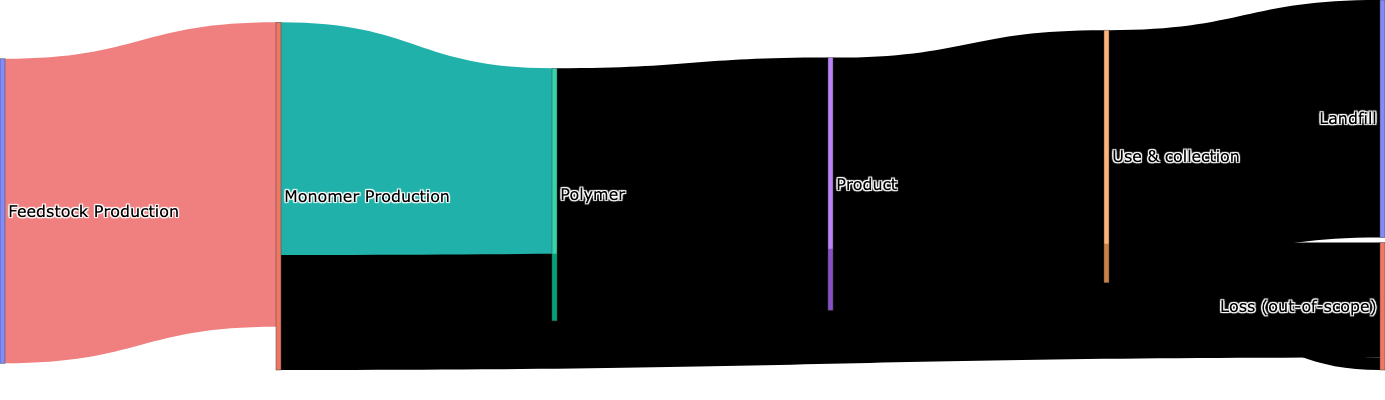

<Figure size 640x480 with 0 Axes>

In [120]:
# graph the Sankey
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    paper_bgcolor = '#FFFFFF', 
)
# Update the layout
fig.update_layout(
    hovermode='x',
    paper_bgcolor='#FFFFFF',
    margin=dict(l=0, r=0, t=0, b=30), # Adjust margins to give more space for flows
    font_size=16,
    font_color='black'
)
fig.update_layout(
    width=900,  # Decrease the width
    height=400  # Decrease the height
)
plt.savefig('min_gwp.pdf', format='pdf')
fig.show()

In [100]:
b=[round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value)]

In [106]:
abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])* model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         

0.0

In [110]:
A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0]

20

In [109]:
A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0]

40

In [108]:
abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])

0.0

In [107]:
model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value

29078312901.27644

In [112]:
abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])* model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value

8371348249.218184

In [116]:
abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])* model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value

3547618491.786369

In [101]:
b[0]/a[0]

0.7507146627594764

In [99]:
a = [round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value)]
a

[170134499997]

In [111]:
 * abs(s[A_df_org.index[A_df_org.iloc[:, 0] == 'market for maleic anhydride | maleic anhydride | APOS, S'].tolist()[0] - 10])
                      + abs(A_modified[A_df_org.index[A_df_org.iloc[:, 0] == 'market for nylon 6 | nylon 6 | APOS, S'].tolist()[0] - 10,
                                        A_df_org.index[A_df_org.iloc[:, 0] == 'market for nylon 6 | nylon 6 | APOS, S'].tolist()[0] - 10])
                      * abs(s[A_df_org.index[A_df_org.iloc[:, 0] == 'market for nylon 6 | nylon 6 | APOS, S'].tolist()[0] - 10]),

    
    
    
    round(abs(A[A_df_org.index[A_df_org.iloc[:, 0] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.index[A_df_org.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
                      * abs(s[A_df_org.index[A_df_org.iloc[:, 0] == 'market for maleic anhydride | maleic anhydride | APOS, S'].tolist()[0] - 10])
                      + abs(A_modified[A_df_org.index[A_df_org.iloc[:, 0] == 'market for nylon 6 | nylon 6 | APOS, S'].tolist()[0] - 10,
                                        A_df_org.index[A_df_org.iloc[:, 0] == 'market for nylon 6 | nylon 6 | APOS, S'].tolist()[0] - 10])
                      * abs(s[A_df_org.index[A_df_org.iloc[:, 0] == 'market for nylon 6 | nylon 6 | APOS, S'].tolist()[0] - 10])

          
          
model.s[j].value

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 9)

# Scenario 1: EoL

## b:  Electricity generation UUIDs in USLCI

In [12]:
electricity_processes = ['Electrcity, solar photovoltatic',
                         'Electricity',
                         'Electricity, at cogen, for natural gas turbine',
                         'Electricity, at Grid, US, 2010',
                         'Electricity, biomass, at power plant',
                         'Electricity, bituminous coal, at power plant',
                         'Electricity, concentrated solar power (CSP)',
                         'Electricity, diesel, at power plant',
                         'Electricity, Eastern US, 2014',
                         'Electricity, lignite coal, at power plant',
                         'Electricity, natural gas, at power plant',
                         'Electricity, nuclear, at power plant',
                         'Electricity, residual fuel oil, at power plant',
                         'Electricity, solar'
                            ]

In [13]:
#finding columns in A with electricity generation
store_index_electricity_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_col.append(stored_index_A)

In [14]:
#finding rows in A with electricity generation
store_index_electricity_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_row.append(stored_index_A)

In [15]:
#finding columns in B with electricity generation
store_index_electricity_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in electricity_processes:
        stored_index_B = i
        store_index_electricity_B.append(stored_index_B)

### Removing corresponding electricity columns from A and B

In [16]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_electricity_B], axis=1)

### Aggregating all electricity flows in each process

In [17]:
electricity_sums = np.sum(np.array(A_df_org.loc[store_index_electricity_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float), axis=0)

In [18]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [19]:
A_df_org = A_df_org_tr.T

In [20]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [21]:
B_df_org = B_df_org_tr.T

### Removing electricity rows from A

In [22]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_row], axis=0)

### Add new electricity rows and columns

In [23]:
new_elec = [
        'Electricity',
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

new_elec_row = [
        'Electricity',
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

In [24]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_elec_df = pd.DataFrame(new_elec_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_elec_df], ignore_index=True)

In [25]:
# Append new columns in A
for elec in new_elec:
    A_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    A_df_org.at[0, elec] = elec  # Set the value in the first row

In [26]:
# Append new columns in B
for elec in new_elec:
    B_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    B_df_org.at[0, elec] = elec  # Set the value in the first row

In [27]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [28]:
A_df_org = A_df_org_tr.T

In [29]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [30]:
B_df_org = B_df_org_tr.T

In [31]:
A_df_org.reset_index(drop=True, inplace=True)

In [32]:
A_df_org.to_csv('A_df_org_electricity.csv', index=False)
B_df_org.to_csv('B_df_org_electricity.csv', index=False)

## Heat

In [33]:
heat_processes = [
    '73cd1596-214d-3403-87f1-f69fc3818886', #'Bituminous coal, combusted in industrial boiler',
    'e04995fa-935b-316c-b112-5b436c8ea3d6', #'Diesel, combusted in industrial boiler',
    'f6e5887d-644b-44ee-bb9d-5c2fd3d07b4a', #'Heat',
    '97624ce0-6d6a-3376-bfa7-c663b3c7e48d', #'Heat, onsite boiler, hardwood mill, average, SE',
    '833c3f72-fbbe-37ea-adf8-929b47ec0255', #'Heat, onsite boiler, hardwood mill, average, SE',
    'eb6394c1-0d19-3be3-99ab-ec572dec9926', #'Lignite coal, combusted in industrial boiler',
    'f77da622-e84d-3639-8917-fcf792aaee13', #'Liquefied petroleum gas, combusted in industrial boiler',
    'bb1dc159-fe13-3f8e-8197-361e8c770ba3', #'Natural gas, combusted in industrial boiler',
    'f179160d-d402-3e37-8d65-93d09f309b99', #'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
    'ea080df3-3823-3f40-89ed-1a45b561230e', #'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
    '654a5cf6-185f-3d91-89ef-42442d1825e8', #'Residual fuel oil, combusted in industrial boiler',
    '75c3bc19-9aeb-30a9-a43f-c862c7354c85', #Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE
    'ccf86743-6a0f-39d5-949e-6b2950bae209', #Wood fuel, hardwood, purchased, combusted in industrial boiler, SE
    'ba4fbc4f-a9ab-387c-8bdd-9308dc19f404', #Wood fuel, unspecified
    '1a76ed77-b97d-3070-85b7-b1f41906cece', #Wood waste, unspecified, combusted in industrial boiler
]

In [34]:
Mj_per_unit = [23.9, #'Bituminous coal, combusted in industrial boiler',
               37.4, #'Diesel, combusted in industrial boiler',
               1, #'Heat',
               1, #'Heat, onsite boiler, hardwood mill, average, SE',
               1, #'Heat, onsite boiler, hardwood mill, average, SE',
               23.9, #'Lignite coal, combusted in industrial boiler',
               26, #'Liquefied petroleum gas, combusted in industrial boiler',
               40, #'Natural gas, combusted in industrial boiler',
               40, #'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
               40, #'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
               37, #'Residual fuel oil, combusted in industrial boiler',
               16, #Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE
               16, #Wood fuel, hardwood, purchased, combusted in industrial boiler, SE
               16, #Wood fuel, unspecified
               16] #Wood waste, unspecified, combusted in industrial boiler

In [35]:
boiler_efficiency = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
#step 1: identify all heat columns in A and B
#finding columns in A with electricity generation
store_index_heat_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[3, i]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_col.append(stored_index_A)

In [37]:
store_index_heat_A_col

[26, 36, 51, 52, 53, 69, 71, 91, 92, 93, 120, 131, 132, 133, 134]

In [38]:
#finding rows in A with electricity generation
store_index_heat_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 3]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_row.append(stored_index_A)

In [39]:
store_index_heat_A_row

[25, 34, 43, 44, 45, 58, 60, 76, 77, 78, 99, 109, 110, 111, 112]

In [40]:
#finding columns in B with electricity generation
#finding columns in B with electricity generation
store_index_heat_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[3, i]) in heat_processes:
        stored_index_B = i
        store_index_heat_B.append(stored_index_B)

In [41]:
store_index_heat_B

[23, 33, 48, 49, 50, 66, 68, 88, 89, 90, 117, 128, 129, 130, 131]

In [42]:
#Step 2: Remove heat columns from A and B
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_heat_B], axis=1)

In [43]:
A_df_org.to_csv('A_df_org_heat-1.csv', index=False)
B_df_org.to_csv('B_df_org_heat-1.csv', index=False)

In [44]:
X = np.array(Mj_per_unit) * np.array(boiler_efficiency)
Y = np.array(A_df_org.loc[store_index_heat_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float)

In [45]:
#Step 3: aggregate heat rows from A and B and convert them to absolute heat needed
heat_sums = []
heat_sums = np.transpose(Y)@X

In [46]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_row], axis=0)
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org.reset_index(drop=True, inplace=True)

In [47]:
A_df_org.to_csv('A_df_org_heat-2.csv', index=False)
B_df_org.to_csv('B_df_org_heat-2.csv', index=False)

In [48]:
update_store_index_heat_A_col = [x-10 for x in store_index_heat_A_col]

In [49]:
update_store_index_heat_A_col

[16, 26, 41, 42, 43, 59, 61, 81, 82, 83, 110, 121, 122, 123, 124]

In [50]:
electricity_sums = np.delete(electricity_sums,update_store_index_heat_A_col)

In [51]:
for i in range(len(heat_sums)-len(electricity_sums)):
    electricity_sums = np.append(electricity_sums, 0)

### Add new heat rows and columns

In [52]:
new_heat = [
        'Heat',
        'Heat, oil',
        'Heat, coal',
        'Heat, natural gas',
        'Heat, traditional biomass']

new_heat_row = [
        'Heat',
        'Heat, oil',
        'Heat, coal',
        'Heat, natural gas',
        'Heat, traditional biomass']

In [53]:
for i in range(len(new_heat)):
    electricity_sums = np.append(electricity_sums, 0)

In [54]:
for i in range(len(new_heat)):
    heat_sums = np.append(heat_sums, 0)

In [55]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_heat_df = pd.DataFrame(new_heat_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_heat_df], ignore_index=True)

In [56]:
# Append new columns in A
for heat in new_heat:
    A_df_org[heat] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, heat in enumerate(new_heat):
    A_df_org.at[0, heat] = heat  # Set the value in the first row

In [57]:
# Append new columns in B
for heat in new_heat:
    B_df_org[heat] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, heat in enumerate(new_heat):
    B_df_org.at[0, heat] = heat  # Set the value in the first row

In [58]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org.reset_index(drop=True, inplace=True)

In [59]:
A_df_org.to_csv('A_df_org_heat.csv', index=False)
B_df_org.to_csv('B_df_org_heat.csv', index=False)

### Add electricity and heat values to A and B

In [60]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],i+10] = electricity_sums[i]

In [61]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat'].tolist()[0],i+10] = heat_sums[i]

In [62]:
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.23

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.36

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.03

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.09

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, wind'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.08

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, solar'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.06

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.14

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.02

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 0

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 0

#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, wind'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, wind'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, solar'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, solar'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0]] = 1

In [63]:
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.34

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.28

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, natural gas'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.25

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.13

#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, natural gas'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, natural gas'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0]] = 1

In [64]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, natural gas '].tolist()[0]] = 0.460/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, coal'].tolist()[0]] = 1/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, oil'].tolist()[0]] = 0.841/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, nuclear'].tolist()[0]] = 0.016/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, wind'].tolist()[0]] = 0.011/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, solar'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, hydropower'].tolist()[0]] = 0.0065/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, biopower'].tolist()[0]] = 0.039/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, geothermal'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, ocean energy'].tolist()[0]] = 0.008/3.6

In [65]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, oil'].tolist()[0]] = 0.072

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, coal'].tolist()[0]] = 0.101

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, natural gas'].tolist()[0]] = 0.056

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, traditional biomass'].tolist()[0]] = 0.025

In [66]:
A_df_org.to_csv('A_df_org_heat-5.csv', index=False)
B_df_org.to_csv('B_df_org_heat-5.csv', index=False)

## Generation of A, B, and C

In [67]:
A_df = copy.copy(A_df_org)
B_df = copy.copy(B_df_org)

In [68]:
#Building A matrix
# Step 1: Delete the first 10 columns
A_df = A_df.drop(A_df.columns[:10], axis=1)

# Step 2: Delete the first 10 rows 
A_df = A_df.iloc[10:]

#Replacing empty values with zero and getting the final A matrix
A=A_df
A=A.replace(np.nan, 0)
A=np.array(A,dtype='float64')

In [69]:
# Building B matrix
# Step 1: Delete the first 7 columns
B_df = B_df.drop(B_df.columns[:7], axis=1)

# Step 2: Delete the first 10 rows (first row is heading, so put 3)
B_df = B_df.iloc[10:]

# Replacing empty values with zero
B_df = B_df.replace(np.nan, 0)

# Converting all elements to float, handling empty strings and stripping whitespace
def convert_to_float(x):
    if isinstance(x, str):
        x = x.strip()  # Remove any leading/trailing whitespace
        if x == '':  # Handle empty strings
            return 0.0
        try:
            return float(x)
        except ValueError:
            return 0.0  # Or raise an error if you want to catch non-numeric strings
    return x

B_df = B_df.applymap(convert_to_float)

# Converting to a NumPy array
B = np.array(B_df, dtype=float)

In [70]:
#Building C matrix
# Step 1: Delete the first 7 columns
C_df = C_df.drop(C_df.columns[:7], axis=1)

# Step 2: Delete the first 5 rows (first row is heading, so put 3)
C_df = C_df.iloc[5:]

#Replacing empty values with zero and getting the final B matrix
C=C_df
C=C.replace(np.nan, 0)
C=np.array(C,dtype='float64')

In [71]:
#Functional Unit
# F = 168.450 million metric tons = 168,450,000 metric tons = 168,450,000,000 kg
F=168450000000
F=int(F)
#defining f matrix
f=np.zeros(len(A))
f[0]=F

In [72]:
C_gwp_wo_seq= np.transpose(C)[[0]]
coef_GWP_wo_seq = C_gwp_wo_seq@B
coef_GWP_wo_seq = np.array(coef_GWP_wo_seq)
coef_GWP_wo_seq = coef_GWP_wo_seq.reshape(-1)

In [73]:
#Model Formulation
# Create the model
model = ConcreteModel()
# List of processes with negative scaling factor due to open loop recovery and substitution approach
negative_s_indices = []
positive_s_indices = []
all_s_indices = []

search_elements_zero = ['High-tech MRF',
                        #'Med-tech MRF',
                        #'Low-tech MRF',
                        'bio-ethylene production (monomer)',
                        'bio-propylene production (monomer)',
                        'bio-EG production (monomer)',
                        'bio-styrene production (monomer)',
                        'bio-vinyl chloride production (monomer)',]

search_elements_zero_or_negative = []

search_elements_zero_or_negative_or_positive = []

#Search for elements in the first row of the DataFrame
negative_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero_or_negative]
negative_s_indices = [i-9 for i in negative_s_indices]
zero_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero]
zero_s_indices = [i-9 for i in zero_s_indices]
all_s_indices = list(range(1, len(np.transpose(A))+1))
positive_s_indices = all_s_indices


# Define the decision variable
model.set_s = RangeSet(len(np.transpose(A)))
model.s = Var(model.set_s)
model.set_negative_scale = Set(initialize=negative_s_indices)
model.set_positive_scale = Set(initialize=positive_s_indices)
model.set_zero_scale = Set(initialize=zero_s_indices)


e = 0
#model constraint: As = f and s>=0
model.set_balance = RangeSet(len(f))
def balance(model, p): # As = f
    return sum(A[p-1,i-1]*model.s[i] for i in model.set_s) == f[p-1]
def negative_scale(model, i):
    return (model.s[i]<=0)
def positive_scale(model, i):
    return (model.s[i]>=e)
def zero_scale(model, i):
    return (model.s[i]==e)

model.balance_constraints = Constraint(model.set_balance, rule=balance)
#model.negative_scale_constraints = Constraint(model.set_negative_scale, rule=negative_scale)
model.positive_scale_constraints = Constraint(model.set_positive_scale, rule=positive_scale)
model.zero_scale_constraints = Constraint(model.set_zero_scale, rule=zero_scale)


model.obj = Objective(expr = sum(coef_GWP_wo_seq[i-1]*model.s[i] for i in model.set_s), sense=minimize)
#Solver
solver = SolverFactory('gurobi')
solver.solve(model) # solves and updates instance

{'Problem': [{'Name': 'x128', 'Lower bound': 250781611354.24124, 'Upper bound': 250781611354.24124, 'Number of objectives': 1, 'Number of constraints': 239, 'Number of variables': 128, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 128, 'Number of nonzeros': 669, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.011874914169311523', 'Error rc': 0, 'Time': 0.13109207153320312}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [74]:
#total CO2 emission (kg CO2eq)
GWP_best_wo_seq = value(model.obj)

In [75]:
GWP_best_wo_seq

250781611354.2413

In [76]:
#kg CO2 eq per kg of packaging product
GWP_best_wo_seq_per_kg = value(model.obj)/168450000000 

In [77]:
GWP_best_wo_seq_per_kg

1.48875993680167

In [78]:
scaling_factors_wo_seq = []
for j in model.s:
    scaling_factors_wo_seq.append(model.s[j].value)  

In [79]:
#1. monomer production
#ethylene
ethylene_s_indices = []
scaling_factors_ethylene = []
search_elements_ethylene = [
    'fossil-ethylene production (monomer)',
    'pyrolysis (monomer production), HDPE sorted',
    'pyrolysis (monomer production), LDPE sorted'
]
ethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_ethylene]
ethylene_s_indices = [i-9 for i in ethylene_s_indices]
for j in ethylene_s_indices:
    scaling_factors_ethylene.append(model.s[j].value)
scaling_factors_ethylene

[41933851140.15352, 0.0, 0.0]

In [80]:
#propylene
propylene_s_indices = []
scaling_factors_propylene = []
search_elements_propylene = [
    'fossil-propylene production (monomer)',
    'pyrolysis (monomer production), PP sorted',
]
propylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_propylene]
propylene_s_indices = [i-9 for i in propylene_s_indices]
for j in propylene_s_indices:
    scaling_factors_propylene.append(model.s[j].value)
scaling_factors_propylene   

[17897772039.904514, 0.0]

In [81]:
#MEG
MEG_s_indices = []
scaling_factors_MEG = []
search_elements_MEG = [
    'fossil-EG production (monomer)',
    'fossil-PTA production (monomer)',
    'depolymerization, enzymatic hyrdrolysis, PET sorted',
    'depolymerization, glycolysis, PET sorted'
]
MEG_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_MEG]
MEG_s_indices = [i-9 for i in MEG_s_indices]
for j in MEG_s_indices:
    scaling_factors_MEG.append(model.s[j].value)
scaling_factors_MEG   

[8003191666.057436, 19936108092.82384, 0.0, 0.0]

In [82]:
#styrene
styrene_s_indices = []
scaling_factors_styrene = []
search_elements_styrene = [
    'fossil-styrene production (monomer)',
    'chemical recycling with metal oxide, PS sorted',
]
styrene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_styrene]
styrene_s_indices = [i-9 for i in styrene_s_indices]
for j in styrene_s_indices:
    scaling_factors_styrene.append(model.s[j].value)
scaling_factors_styrene 

[4950906029.9179535, 0.0]

In [83]:
#vinyl chloride
vinyl_chloride_s_indices = []
scaling_factors_vinyl_chloride = []
search_elements_vinyl_chloride = [
    'fossil-vinyl chloride production (monomer)',
]
vinyl_chloride_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_vinyl_chloride]
vinyl_chloride_s_indices = [i-9 for i in vinyl_chloride_s_indices]
for j in vinyl_chloride_s_indices:
    scaling_factors_vinyl_chloride.append(model.s[j].value)
scaling_factors_vinyl_chloride  

[2047222703.169283]

In [86]:
# 2. polymers
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'advanced recycling, delamination, multi-layer plastic packaging',
    'LDPE production',
    'mechanical recycling, LDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 20425908923.105957, 15613837013.467352]

In [87]:
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'HDPE production',
    'mechanical recycling, HDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 21817563062.337997, 16435449829.503]

In [88]:
#polypropylene
scaling_factors_polypropylene = []
polypropylene_s_indices = []
search_elements_polypropylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PP production',
    'mechanical recycling, PP sorted'
]
polypropylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polypropylene]
polypropylene_s_indices = [i-9 for i in polypropylene_s_indices]
for j in polypropylene_s_indices:
    scaling_factors_polypropylene.append(model.s[j].value)
scaling_factors_polypropylene

[0.0, 0.0, 29672055324.770195, 22352339516.157]

In [89]:
#polyethylene terephthalate
scaling_factors_PET = []
PET_s_indices = []
search_elements_PET = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PET production',
    'mechanical recycling, PET sorted'
]
PET_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PET]
PET_s_indices = [i-9 for i in PET_s_indices]
for j in PET_s_indices:
    scaling_factors_PET.append(model.s[j].value)
scaling_factors_PET

[0.0, 0.0, 23184216877.33904, 17001591710.417252]

In [90]:
#polystyrene terephthalate
scaling_factors_PS = []
PS_s_indices = []
search_elements_PS = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PS production',
    'mechanical recycling, PS sorted'
]
PS_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PS]
PS_s_indices = [i-9 for i in PS_s_indices]
for j in PS_s_indices:
    scaling_factors_PS.append(model.s[j].value)
scaling_factors_PS

[0.0, 0.0, 5021202870.099344, 3913062690.073875]

In [91]:
#polyvinyl chloride
scaling_factors_PVC = []
PVC_s_indices = []
search_elements_PVC = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PVC production',
    'mechanical recycling, PVC sorted'
]
PVC_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PVC]
PVC_s_indices = [i-9 for i in PVC_s_indices]
for j in PVC_s_indices:
    scaling_factors_PVC.append(model.s[j].value)
scaling_factors_PVC

[0.0, 0.0, 2053382851.7244563, 1461078.174929727]

In [92]:
#3. mixed plastic collected waste (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'incineration, electricity recovery, plastic packaging waste',
    'landfill, plastic packaging waste',
    'High-tech MRF',
    'Med-tech MRF',
    'Low-tech MRF',
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 160027500000.0, 0.0]

In [93]:
#4. mixed plastic waste, sorted (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'cement clinker, mixed plastic packaging, sorted',
    'plastic lumber production from sorted mixed plastic waste',
    'pyrolysis, feedstock recycling, mixed plastic waste, sorted',
    'PET fiber production from sorted PET waste',
    'road pavement production from sorted mixed plastic waste'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 60010312500.0, 0.0, 0.0]

In [94]:
#5. Plastic residues
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'landfill, plastic residues',
    'incineration, electricity recovery, plastic residues'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[31708127644.980164, 0.0]

In [95]:
#6. Energy Grid
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[105153099909.28792,
 164587460727.5811,
 13715621727.298424,
 41146865181.89527,
 36574991272.7958,
 27431243454.596848,
 64006234727.39265,
 9143747818.19895,
 0.0,
 0.0]

In [268]:
#colors for links in Sankey

color_link = ['#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080', '#F08080',
              '#F08080', '#F08080', '#F08080']#,'#20B2AA','#FFFFFF','#F08080','#FFFFFF','#FFFFFF','#FFFFFF','#20B2AA','#20B2AA','#FFFFFF','#FF7F50','#FF7F50','#FF7F50','#FF7F50','#FF7F50','#FF7F50','#FFA07A','#FFA07A','#4682B4','#4682B4','#B0C4DE','#B0C4DE','#FFDAB9','#FFDAB9','#E6E6FA','#E6E6FA','#00FF7F','#00FF7F','#FFA07A','#4682B4','#B0C4DE']

#0: '#F08080' (except for 0>1 and 0>2)
#1: '#FFFFFF'
#2: '#FFFFFF'
#3: '#20B2AA' (except for 3>4)
#4: '#FFFFFF'
#5: '#FF7F50'
#6: '#87CEEB'
#7: '#778899'
#8: '#40E0D0'
#9: '#FFA07A'
#10: '#4682B4'
#11: '#B0C4DE'
#12: '#FFDAB9'
#13: '#E6E6FA'
#14: '#00FF7F'

#source = [0,0,0,0,1,2,3,3,3,4,5,5,5,5,5,5,9,9,10,10,11,11,12,12,13,13,14,12,9,10,11]

In [281]:
# Sankey Diagram
#data
label = ["Feedstock Production","Monomer Production",
        "Polymer","Product","Use & collection","Sorting","Advanced Recycling", "Mechanical Recycling",
        "Monomer Recycling", "Feedstock Recycling", "Landfill", "Loss (out-of-scope)"]
#0: Feedstock
#1: Monomer
#2: Polymer
#3: Product
#4: Use & collection
#5: Sorting
#6: Advanced Recycling
#7: Mechanical Recycling
#8: Monomer Recycling
#9: Feedstock Recycling
#10: Landfill
#11: Loss

#source = [0,1, 1, 1, 2, 3,2,3,4,5,6, 6,7,7, 7, 7, 7,8,9,10,11]
#target = [1,2,11,13, 3, 13,13,3,4,5,6,7,12,8,9,10,11,12,5,5, 4, 3]

source = [0,1,9, 1,2, 2,6,7,3,4, 4, 4,5,5,5,5, 5, 7,8,8, 9]
target = [1,2,1,11,3,11,3,3,4,5,10,11,6,7,8,9,10,10,2,1,11]
value = [
    ######### 0 >>>> 1 #########
     round(
         (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value),
    
    ########### 1 >>>> 2 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
     
    ########### 9 >>>> 1 ##############
    
     round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
   
    
    ########### 1 >>>> 11 ##############
    
        round( 
        (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
     - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value

    + 0.15/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
    
    ########### 2 >>>> 3 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
    ########### 3 >>>> 11 #############
    
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
     
    
       - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
     
    ######### 6 >>>> 3 #########
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
    
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    
    
    
    ######### 7 >>>> 3 #########
    
    round( 
       
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'small-format plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 10 #####\
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging consumption'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 9].value
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value
    
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
        
      ##### 5 >>>>>> 6 #####
        round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
            +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 7 #####
    round( 
    abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 8 #####
    round(
        
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
        ##### 5 >>>>>> 9 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
        
        ##### 5 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 7 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
       ##### 8 >>>>>> 2 #####

    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
     ##### 8 >>>>>> 1 #####

    round(
     abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value),
    
     ##### 9 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
    - ( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value))

]

#data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label, pad=5, thickness=5)

data = go.Sankey(arrangement="snap", link = link, node=node, valueformat = ".2f",
    valuesuffix = " MT")

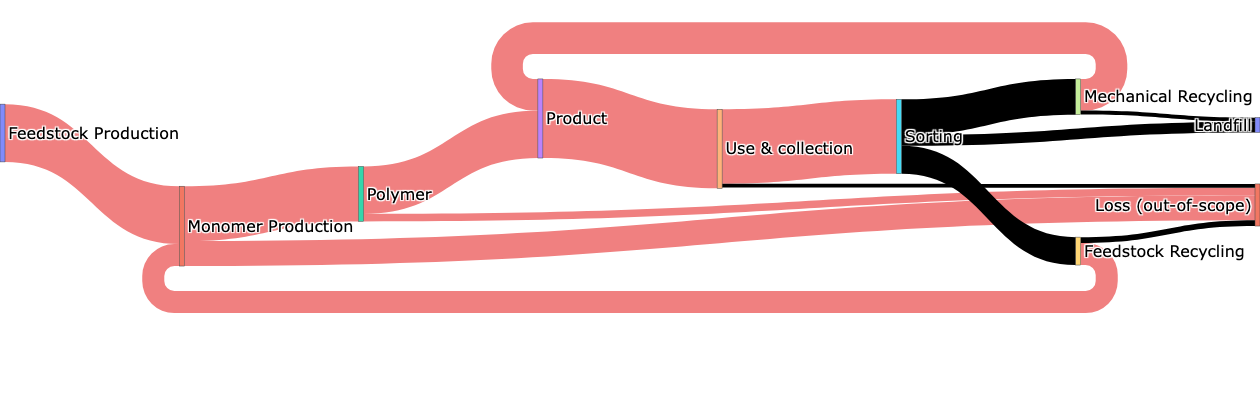

<Figure size 640x480 with 0 Axes>

In [282]:
# graph the Sankey
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    paper_bgcolor = '#FFFFFF', 
)
# Update the layout
fig.update_layout(
    hovermode='x',
    paper_bgcolor='#FFFFFF',
    margin=dict(l=0, r=0, t=0, b=30), # Adjust margins to give more space for flows
    font_size=16,
    font_color='black'
)
fig.update_layout(
    width=900,  # Decrease the width
    height=400  # Decrease the height
)
plt.savefig('min_gwp.pdf', format='pdf')
fig.show()

# Scenario 2: EoL + high-tech Sorting

## b:  Electricity generation UUIDs in USLCI

In [12]:
electricity_processes = ['Electrcity, solar photovoltatic',
                         'Electricity',
                         'Electricity, at cogen, for natural gas turbine',
                         'Electricity, at Grid, US, 2010',
                         'Electricity, biomass, at power plant',
                         'Electricity, bituminous coal, at power plant',
                         'Electricity, concentrated solar power (CSP)',
                         'Electricity, diesel, at power plant',
                         'Electricity, Eastern US, 2014',
                         'Electricity, lignite coal, at power plant',
                         'Electricity, natural gas, at power plant',
                         'Electricity, nuclear, at power plant',
                         'Electricity, residual fuel oil, at power plant',
                         'Electricity, solar'
                            ]

In [13]:
#finding columns in A with electricity generation
store_index_electricity_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_col.append(stored_index_A)

In [14]:
#finding rows in A with electricity generation
store_index_electricity_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_row.append(stored_index_A)

In [15]:
#finding columns in B with electricity generation
store_index_electricity_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in electricity_processes:
        stored_index_B = i
        store_index_electricity_B.append(stored_index_B)

### Removing corresponding electricity columns from A and B

In [16]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_electricity_B], axis=1)

### Aggregating all electricity flows in each process

In [17]:
electricity_sums = np.sum(np.array(A_df_org.loc[store_index_electricity_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float), axis=0)

In [18]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [19]:
A_df_org = A_df_org_tr.T

In [20]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [21]:
B_df_org = B_df_org_tr.T

### Removing electricity rows from A

In [22]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_row], axis=0)

### Add new electricity rows and columns

In [23]:
new_elec = [
        'Electricity',
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

new_elec_row = [
        'Electricity',
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

In [24]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_elec_df = pd.DataFrame(new_elec_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_elec_df], ignore_index=True)

In [25]:
# Append new columns in A
for elec in new_elec:
    A_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    A_df_org.at[0, elec] = elec  # Set the value in the first row

In [26]:
# Append new columns in B
for elec in new_elec:
    B_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    B_df_org.at[0, elec] = elec  # Set the value in the first row

In [27]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [28]:
A_df_org = A_df_org_tr.T

In [29]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [30]:
B_df_org = B_df_org_tr.T

In [31]:
A_df_org.reset_index(drop=True, inplace=True)

In [32]:
A_df_org.to_csv('A_df_org_electricity.csv', index=False)
B_df_org.to_csv('B_df_org_electricity.csv', index=False)

## Heat

In [33]:
heat_processes = [
    '73cd1596-214d-3403-87f1-f69fc3818886', #'Bituminous coal, combusted in industrial boiler',
    'e04995fa-935b-316c-b112-5b436c8ea3d6', #'Diesel, combusted in industrial boiler',
    'f6e5887d-644b-44ee-bb9d-5c2fd3d07b4a', #'Heat',
    '97624ce0-6d6a-3376-bfa7-c663b3c7e48d', #'Heat, onsite boiler, hardwood mill, average, SE',
    '833c3f72-fbbe-37ea-adf8-929b47ec0255', #'Heat, onsite boiler, hardwood mill, average, SE',
    'eb6394c1-0d19-3be3-99ab-ec572dec9926', #'Lignite coal, combusted in industrial boiler',
    'f77da622-e84d-3639-8917-fcf792aaee13', #'Liquefied petroleum gas, combusted in industrial boiler',
    'bb1dc159-fe13-3f8e-8197-361e8c770ba3', #'Natural gas, combusted in industrial boiler',
    'f179160d-d402-3e37-8d65-93d09f309b99', #'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
    'ea080df3-3823-3f40-89ed-1a45b561230e', #'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
    '654a5cf6-185f-3d91-89ef-42442d1825e8', #'Residual fuel oil, combusted in industrial boiler',
    '75c3bc19-9aeb-30a9-a43f-c862c7354c85', #Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE
    'ccf86743-6a0f-39d5-949e-6b2950bae209', #Wood fuel, hardwood, purchased, combusted in industrial boiler, SE
    'ba4fbc4f-a9ab-387c-8bdd-9308dc19f404', #Wood fuel, unspecified
    '1a76ed77-b97d-3070-85b7-b1f41906cece', #Wood waste, unspecified, combusted in industrial boiler
]

In [34]:
Mj_per_unit = [23.9, #'Bituminous coal, combusted in industrial boiler',
               37.4, #'Diesel, combusted in industrial boiler',
               1, #'Heat',
               1, #'Heat, onsite boiler, hardwood mill, average, SE',
               1, #'Heat, onsite boiler, hardwood mill, average, SE',
               23.9, #'Lignite coal, combusted in industrial boiler',
               26, #'Liquefied petroleum gas, combusted in industrial boiler',
               40, #'Natural gas, combusted in industrial boiler',
               40, #'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
               40, #'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
               37, #'Residual fuel oil, combusted in industrial boiler',
               16, #Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE
               16, #Wood fuel, hardwood, purchased, combusted in industrial boiler, SE
               16, #Wood fuel, unspecified
               16] #Wood waste, unspecified, combusted in industrial boiler

In [35]:
boiler_efficiency = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
#step 1: identify all heat columns in A and B
#finding columns in A with electricity generation
store_index_heat_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[3, i]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_col.append(stored_index_A)

In [37]:
store_index_heat_A_col

[26, 36, 51, 52, 53, 69, 71, 91, 92, 93, 120, 131, 132, 133, 134]

In [38]:
#finding rows in A with electricity generation
store_index_heat_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 3]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_row.append(stored_index_A)

In [39]:
store_index_heat_A_row

[25, 34, 43, 44, 45, 58, 60, 76, 77, 78, 99, 109, 110, 111, 112]

In [40]:
#finding columns in B with electricity generation
#finding columns in B with electricity generation
store_index_heat_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[3, i]) in heat_processes:
        stored_index_B = i
        store_index_heat_B.append(stored_index_B)

In [41]:
store_index_heat_B

[23, 33, 48, 49, 50, 66, 68, 88, 89, 90, 117, 128, 129, 130, 131]

In [42]:
#Step 2: Remove heat columns from A and B
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_heat_B], axis=1)

In [43]:
A_df_org.to_csv('A_df_org_heat-1.csv', index=False)
B_df_org.to_csv('B_df_org_heat-1.csv', index=False)

In [44]:
X = np.array(Mj_per_unit) * np.array(boiler_efficiency)
Y = np.array(A_df_org.loc[store_index_heat_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float)

In [45]:
#Step 3: aggregate heat rows from A and B and convert them to absolute heat needed
heat_sums = []
heat_sums = np.transpose(Y)@X

In [46]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_row], axis=0)
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org.reset_index(drop=True, inplace=True)

In [47]:
A_df_org.to_csv('A_df_org_heat-2.csv', index=False)
B_df_org.to_csv('B_df_org_heat-2.csv', index=False)

In [48]:
update_store_index_heat_A_col = [x-10 for x in store_index_heat_A_col]

In [49]:
update_store_index_heat_A_col

[16, 26, 41, 42, 43, 59, 61, 81, 82, 83, 110, 121, 122, 123, 124]

In [50]:
electricity_sums = np.delete(electricity_sums,update_store_index_heat_A_col)

In [51]:
for i in range(len(heat_sums)-len(electricity_sums)):
    electricity_sums = np.append(electricity_sums, 0)

### Add new heat rows and columns

In [52]:
new_heat = [
        'Heat',
        'Heat, oil',
        'Heat, coal',
        'Heat, natural gas',
        'Heat, traditional biomass']

new_heat_row = [
        'Heat',
        'Heat, oil',
        'Heat, coal',
        'Heat, natural gas',
        'Heat, traditional biomass']

In [53]:
for i in range(len(new_heat)):
    electricity_sums = np.append(electricity_sums, 0)

In [54]:
for i in range(len(new_heat)):
    heat_sums = np.append(heat_sums, 0)

In [55]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_heat_df = pd.DataFrame(new_heat_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_heat_df], ignore_index=True)

In [56]:
# Append new columns in A
for heat in new_heat:
    A_df_org[heat] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, heat in enumerate(new_heat):
    A_df_org.at[0, heat] = heat  # Set the value in the first row

In [57]:
# Append new columns in B
for heat in new_heat:
    B_df_org[heat] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, heat in enumerate(new_heat):
    B_df_org.at[0, heat] = heat  # Set the value in the first row

In [58]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org.reset_index(drop=True, inplace=True)

In [59]:
A_df_org.to_csv('A_df_org_heat.csv', index=False)
B_df_org.to_csv('B_df_org_heat.csv', index=False)

### Add electricity and heat values to A and B

In [60]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],i+10] = electricity_sums[i]

In [61]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat'].tolist()[0],i+10] = heat_sums[i]

In [62]:
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.23

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.36

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.03

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.09

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, wind'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.08

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, solar'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.06

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.14

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.02

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 0

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 0

#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, wind'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, wind'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, solar'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, solar'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0]] = 1

In [63]:
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.34

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.28

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, natural gas'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.25

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.13

#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, natural gas'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, natural gas'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0]] = 1

In [64]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, natural gas '].tolist()[0]] = 0.460/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, coal'].tolist()[0]] = 1/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, oil'].tolist()[0]] = 0.841/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, nuclear'].tolist()[0]] = 0.016/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, wind'].tolist()[0]] = 0.011/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, solar'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, hydropower'].tolist()[0]] = 0.0065/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, biopower'].tolist()[0]] = 0.039/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, geothermal'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, ocean energy'].tolist()[0]] = 0.008/3.6

In [65]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, oil'].tolist()[0]] = 0.072

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, coal'].tolist()[0]] = 0.101

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, natural gas'].tolist()[0]] = 0.056

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, traditional biomass'].tolist()[0]] = 0.025

In [66]:
A_df_org.to_csv('A_df_org_heat-5.csv', index=False)
B_df_org.to_csv('B_df_org_heat-5.csv', index=False)

## Generation of A, B, and C

In [67]:
A_df = copy.copy(A_df_org)
B_df = copy.copy(B_df_org)

In [68]:
#Building A matrix
# Step 1: Delete the first 10 columns
A_df = A_df.drop(A_df.columns[:10], axis=1)

# Step 2: Delete the first 10 rows 
A_df = A_df.iloc[10:]

#Replacing empty values with zero and getting the final A matrix
A=A_df
A=A.replace(np.nan, 0)
A=np.array(A,dtype='float64')

In [69]:
# Building B matrix
# Step 1: Delete the first 7 columns
B_df = B_df.drop(B_df.columns[:7], axis=1)

# Step 2: Delete the first 10 rows (first row is heading, so put 3)
B_df = B_df.iloc[10:]

# Replacing empty values with zero
B_df = B_df.replace(np.nan, 0)

# Converting all elements to float, handling empty strings and stripping whitespace
def convert_to_float(x):
    if isinstance(x, str):
        x = x.strip()  # Remove any leading/trailing whitespace
        if x == '':  # Handle empty strings
            return 0.0
        try:
            return float(x)
        except ValueError:
            return 0.0  # Or raise an error if you want to catch non-numeric strings
    return x

B_df = B_df.applymap(convert_to_float)

# Converting to a NumPy array
B = np.array(B_df, dtype=float)

In [70]:
#Building C matrix
# Step 1: Delete the first 7 columns
C_df = C_df.drop(C_df.columns[:7], axis=1)

# Step 2: Delete the first 5 rows (first row is heading, so put 3)
C_df = C_df.iloc[5:]

#Replacing empty values with zero and getting the final B matrix
C=C_df
C=C.replace(np.nan, 0)
C=np.array(C,dtype='float64')

In [71]:
#Functional Unit
# F = 168.450 million metric tons = 168,450,000 metric tons = 168,450,000,000 kg
F=168450000000
F=int(F)
#defining f matrix
f=np.zeros(len(A))
f[0]=F

In [72]:
C_gwp_wo_seq= np.transpose(C)[[0]]
coef_GWP_wo_seq = C_gwp_wo_seq@B
coef_GWP_wo_seq = np.array(coef_GWP_wo_seq)
coef_GWP_wo_seq = coef_GWP_wo_seq.reshape(-1)

In [73]:
#Model Formulation
# Create the model
model = ConcreteModel()
# List of processes with negative scaling factor due to open loop recovery and substitution approach
negative_s_indices = []
positive_s_indices = []
all_s_indices = []

search_elements_zero = [#'High-tech MRF',
                        #'Med-tech MRF',
                        #'Low-tech MRF',
                        'bio-ethylene production (monomer)',
                        'bio-propylene production (monomer)',
                        'bio-EG production (monomer)',
                        'bio-styrene production (monomer)',
                        'bio-vinyl chloride production (monomer)',]

search_elements_zero_or_negative = []

search_elements_zero_or_negative_or_positive = []

#Search for elements in the first row of the DataFrame
negative_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero_or_negative]
negative_s_indices = [i-9 for i in negative_s_indices]
zero_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero]
zero_s_indices = [i-9 for i in zero_s_indices]
all_s_indices = list(range(1, len(np.transpose(A))+1))
positive_s_indices = all_s_indices


# Define the decision variable
model.set_s = RangeSet(len(np.transpose(A)))
model.s = Var(model.set_s)
model.set_negative_scale = Set(initialize=negative_s_indices)
model.set_positive_scale = Set(initialize=positive_s_indices)
model.set_zero_scale = Set(initialize=zero_s_indices)


e = 0
#model constraint: As = f and s>=0
model.set_balance = RangeSet(len(f))
def balance(model, p): # As = f
    return sum(A[p-1,i-1]*model.s[i] for i in model.set_s) == f[p-1]
def negative_scale(model, i):
    return (model.s[i]<=0)
def positive_scale(model, i):
    return (model.s[i]>=e)
def zero_scale(model, i):
    return (model.s[i]==e)

model.balance_constraints = Constraint(model.set_balance, rule=balance)
#model.negative_scale_constraints = Constraint(model.set_negative_scale, rule=negative_scale)
model.positive_scale_constraints = Constraint(model.set_positive_scale, rule=positive_scale)
model.zero_scale_constraints = Constraint(model.set_zero_scale, rule=zero_scale)


model.obj = Objective(expr = sum(coef_GWP_wo_seq[i-1]*model.s[i] for i in model.set_s), sense=minimize)
#Solver
solver = SolverFactory('gurobi')
solver.solve(model) # solves and updates instance

{'Problem': [{'Name': 'x128', 'Lower bound': 192711620001.48285, 'Upper bound': 192711620001.48285, 'Number of objectives': 1, 'Number of constraints': 238, 'Number of variables': 128, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 128, 'Number of nonzeros': 668, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.010174036026000977', 'Error rc': 0, 'Time': 0.1370868682861328}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [74]:
#total CO2 emission (kg CO2eq)
GWP_best_wo_seq = value(model.obj)

In [75]:
GWP_best_wo_seq

192711620001.48288

In [76]:
#kg CO2 eq per kg of packaging product
GWP_best_wo_seq_per_kg = value(model.obj)/168450000000 

In [77]:
GWP_best_wo_seq_per_kg

1.1440286138408007

In [78]:
scaling_factors_wo_seq = []
for j in model.s:
    scaling_factors_wo_seq.append(model.s[j].value)  

In [79]:
#1. monomer production
#ethylene
ethylene_s_indices = []
scaling_factors_ethylene = []
search_elements_ethylene = [
    'fossil-ethylene production (monomer)',
    'pyrolysis (monomer production), HDPE sorted',
    'pyrolysis (monomer production), LDPE sorted'
]
ethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_ethylene]
ethylene_s_indices = [i-9 for i in ethylene_s_indices]
for j in ethylene_s_indices:
    scaling_factors_ethylene.append(model.s[j].value)
scaling_factors_ethylene

[13691834266.46352, 0.0, 0.0]

In [80]:
#propylene
propylene_s_indices = []
scaling_factors_propylene = []
search_elements_propylene = [
    'fossil-propylene production (monomer)',
    'pyrolysis (monomer production), PP sorted',
]
propylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_propylene]
propylene_s_indices = [i-9 for i in propylene_s_indices]
for j in propylene_s_indices:
    scaling_factors_propylene.append(model.s[j].value)
scaling_factors_propylene   

[6660980804.936775, 0.0]

In [81]:
#MEG
MEG_s_indices = []
scaling_factors_MEG = []
search_elements_MEG = [
    'fossil-EG production (monomer)',
    'depolymerization, enzymatic hyrdrolysis, PET sorted',
    'depolymerization, glycolysis, PET sorted'
]
MEG_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_MEG]
MEG_s_indices = [i-9 for i in MEG_s_indices]
for j in MEG_s_indices:
    scaling_factors_MEG.append(model.s[j].value)
scaling_factors_MEG   

[2985904507.0877905, 0.0, 0.0]

In [82]:
#styrene
styrene_s_indices = []
scaling_factors_styrene = []
search_elements_styrene = [
    'fossil-styrene production (monomer)',
    'chemical recycling with metal oxide, PS sorted',
]
styrene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_styrene]
styrene_s_indices = [i-9 for i in styrene_s_indices]
for j in styrene_s_indices:
    scaling_factors_styrene.append(model.s[j].value)
scaling_factors_styrene 

[1688756840.8414593, 0.0]

In [83]:
#vinyl chloride
vinyl_chloride_s_indices = []
scaling_factors_vinyl_chloride = []
search_elements_vinyl_chloride = [
    'fossil-vinyl chloride production (monomer)',
]
vinyl_chloride_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_vinyl_chloride]
vinyl_chloride_s_indices = [i-9 for i in vinyl_chloride_s_indices]
for j in vinyl_chloride_s_indices:
    scaling_factors_vinyl_chloride.append(model.s[j].value)
scaling_factors_vinyl_chloride  

[578502596.1822491]

In [84]:
# 2. polymers
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'advanced recycling, delamination, multi-layer plastic packaging',
    'LDPE production',
    'mechanical recycling, LDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 18819234.0, 6456698222.681558, 26814375192.7485]

In [85]:
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'HDPE production',
    'mechanical recycling, HDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[18819234.0, 0.0, 7340555390.756783, 28225369457.71275]

In [86]:
#polypropylene
scaling_factors_polypropylene = []
polypropylene_s_indices = []
search_elements_polypropylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PP production',
    'mechanical recycling, PP sorted'
]
polypropylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polypropylene]
polypropylene_s_indices = [i-9 for i in polypropylene_s_indices]
for j in polypropylene_s_indices:
    scaling_factors_polypropylene.append(model.s[j].value)
scaling_factors_polypropylene

[18819234.0, 0.0, 9983212384.287066, 38386721832.027]

In [87]:
#polyethylene terephthalate
scaling_factors_PET = []
PET_s_indices = []
search_elements_PET = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PET production',
    'mechanical recycling, PET sorted'
]
PET_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PET]
PET_s_indices = [i-9 for i in PET_s_indices]
for j in PET_s_indices:
    scaling_factors_PET.append(model.s[j].value)
scaling_factors_PET

[18819234.0, 0.0, 8649781306.743309, 29197631480.53125]

In [88]:
#polystyrene terephthalate
scaling_factors_PS = []
PS_s_indices = []
search_elements_PS = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PS production',
    'mechanical recycling, PS sorted'
]
PS_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PS]
PS_s_indices = [i-9 for i in PS_s_indices]
for j in PS_s_indices:
    scaling_factors_PS.append(model.s[j].value)
scaling_factors_PS

[18819234.0, 0.0, 1712735132.6992488, 6585684505.610024]

In [89]:
#polyvinyl chloride
scaling_factors_PVC = []
PVC_s_indices = []
search_elements_PVC = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PVC production',
    'mechanical recycling, PVC sorted'
]
PVC_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PVC]
PVC_s_indices = [i-9 for i in PVC_s_indices]
for j in PVC_s_indices:
    scaling_factors_PVC.append(model.s[j].value)
scaling_factors_PVC

[18819234.0, 0.0, 580243326.1607313, 2509178.1319714095]

In [90]:
#3. mixed plastic collected waste (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'incineration, electricity recovery, plastic packaging waste',
    'landfill, plastic packaging waste',
    'High-tech MRF',
    'Med-tech MRF',
    'Low-tech MRF',
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 160027500000.0, 0.0, 0.0]

In [91]:
#4. mixed plastic waste, sorted (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'cement clinker, mixed plastic packaging, sorted',
    'plastic lumber production from sorted mixed plastic waste',
    'pyrolysis, feedstock recycling, mixed plastic waste, sorted',
    'PET fiber production from sorted PET waste',
    'road pavement production from sorted mixed plastic waste'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 0.0, 0.0]

In [92]:
#5. Plastic residues
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'landfill, plastic residues',
    'incineration, electricity recovery, plastic residues'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[24017538114.78966, 0.0]

In [93]:
#6. Energy Grid
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[198058799010.88776,
 310005076712.69385,
 25833756392.724487,
 77501269178.17346,
 68890017047.2653,
 51667512785.448975,
 120557529832.7143,
 17222504261.816326,
 0.0,
 0.0]

In [95]:

#colors for links in Sankey



color_link = ['#F08080', '#20B2AA', '#20B2AA']#,'#20B2AA','#FFFFFF','#F08080','#FFFFFF','#FFFFFF','#FFFFFF','#20B2AA','#20B2AA','#FFFFFF','#FF7F50','#FF7F50','#FF7F50','#FF7F50','#FF7F50','#FF7F50','#FFA07A','#FFA07A','#4682B4','#4682B4','#B0C4DE','#B0C4DE','#FFDAB9','#FFDAB9','#E6E6FA','#E6E6FA','#00FF7F','#00FF7F','#FFA07A','#4682B4','#B0C4DE']

#0: '#F08080' (except for 0>1 and 0>2)
#1: '#FFFFFF'
#2: '#FFFFFF'
#3: '#20B2AA' (except for 3>4)
#4: '#FFFFFF'
#5: '#FF7F50'
#6: '#87CEEB'
#7: '#778899'
#8: '#40E0D0'
#9: '#FFA07A'
#10: '#4682B4'
#11: '#B0C4DE'
#12: '#FFDAB9'
#13: '#E6E6FA'
#14: '#00FF7F'

#source = [0,0,0,0,1,2,3,3,3,4,5,5,5,5,5,5,9,9,10,10,11,11,12,12,13,13,14,12,9,10,11]

In [128]:
# Sankey Diagram
#data
label = ["Feedstock Production","Monomer Production",
        "Polymer Production","Packaging Production","Use & collection","Sorting","Advanced Recycling", "Mechanical Recycling",
        "Monomer Recycling", "Feedstock Recycling", "Landfill", "Loss (out-of-scope)"]
#0: Feedstock Production
#1: Monomer Production
#2: Polymer Production 
#3: Plastic Packaging Production
#4: Use & collection
#5: Sorting
#6: Advanced Recycling
#7: Mechanical Recycling
#8: Monomer Recycling
#9: Feedstock Recycling
#10: Landfill
#11: Loss

#source = [0,1, 1, 1, 2, 3,2,3,4,5,6, 6,7,7, 7, 7, 7,8,9,10,11]
#target = [1,2,11,13, 3, 13,13,3,4,5,6,7,12,8,9,10,11,12,5,5, 4, 3]

source = [0,1,9, 1,2, 2,6,7,3,4, 4, 4,5,5,5,5, 5, 7,8,8, 9]
target = [1,2,1,11,3,11,3,3,4,5,10,11,6,7,8,9,10,10,2,1,11]
value = [
    ######### 0 >>>> 1 #########
     round(
         (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value),
     
    ########### 1 >>>> 2 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
        
         + 1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
     
    ########### 9 >>>> 1 ##############
    
     round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
   
    
    ########### 1 >>>> 11 ##############
    
        round( 
        (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
     - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value

    + 0.15/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
    
    ########### 2 >>>> 3 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
    
    ########### 2 >>>> 11 #############
    

       round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
        
         + 1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
           
           +round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value
        
        - (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value))),
    
     
    ######### 6 >>>> 3 #########
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
    
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    
    
    
    ######### 7 >>>> 3 #########
    
    round( 
       
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'small-format plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 10 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging consumption'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 9].value
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value
    
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
        
      ##### 5 >>>>>> 6 #####
        round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
            +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 7 #####
    round( 
    abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 8 #####
    round(
        
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
        ##### 5 >>>>>> 9 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
        
        ##### 5 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 7 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
       ##### 8 >>>>>> 2 #####

    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
     ##### 8 >>>>>> 1 #####

    round(
     abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value),
    
     ##### 9 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
    - ( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value))

]

#data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label, pad=5, thickness=5)

data = go.Sankey(arrangement="snap", link = link, node=node, valueformat = ".2f",
    valuesuffix = " MT")

In [123]:
a = [round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value)]
a

[0]

In [124]:
b = [round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value)]
b

[34723225763]

In [125]:
c=[round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value)]
c

[26382945156]

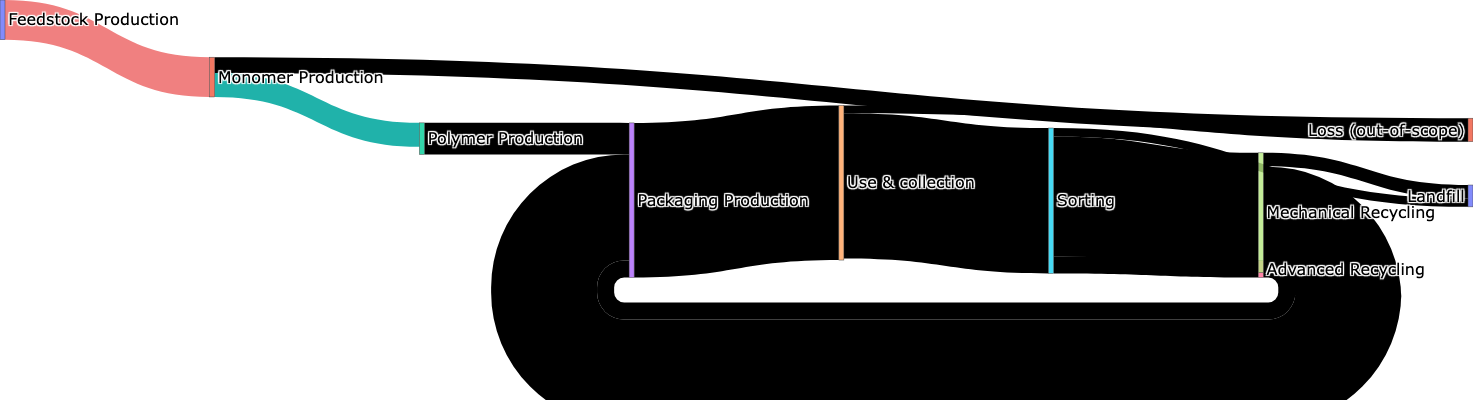

<Figure size 640x480 with 0 Axes>

In [129]:
# graph the Sankey
fig = go.Figure(data)
fig.update_layout(
    hovermode = 'x',
    paper_bgcolor = '#FFFFFF', 
)
# Update the layout
fig.update_layout(
    hovermode='x',
    paper_bgcolor='#FFFFFF',
    margin=dict(l=0, r=0, t=0, b=30), # Adjust margins to give more space for flows
    font_size=16,
    font_color='black'
)
fig.update_layout(
    width=900,  # Decrease the width
    height=400  # Decrease the height
)
plt.savefig('min_gwp.pdf', format='pdf')
fig.show()

# Scenario 3: Renewable

## b:  Electricity generation UUIDs in USLCI

In [12]:
electricity_processes = ['Electrcity, solar photovoltatic',
                         'Electricity',
                         'Electricity, at cogen, for natural gas turbine',
                         'Electricity, at Grid, US, 2010',
                         'Electricity, biomass, at power plant',
                         'Electricity, bituminous coal, at power plant',
                         'Electricity, concentrated solar power (CSP)',
                         'Electricity, diesel, at power plant',
                         'Electricity, Eastern US, 2014',
                         'Electricity, lignite coal, at power plant',
                         'Electricity, natural gas, at power plant',
                         'Electricity, nuclear, at power plant',
                         'Electricity, residual fuel oil, at power plant',
                         'Electricity, solar'
                            ]

In [13]:
#finding columns in A with electricity generation
store_index_electricity_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_col.append(stored_index_A)

In [14]:
#finding rows in A with electricity generation
store_index_electricity_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_row.append(stored_index_A)

In [15]:
#finding columns in B with electricity generation
store_index_electricity_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in electricity_processes:
        stored_index_B = i
        store_index_electricity_B.append(stored_index_B)

### Removing corresponding electricity columns from A and B

In [16]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_electricity_B], axis=1)

### Aggregating all electricity flows in each process

In [17]:
electricity_sums = np.sum(np.array(A_df_org.loc[store_index_electricity_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float), axis=0)

In [18]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [19]:
A_df_org = A_df_org_tr.T

In [20]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [21]:
B_df_org = B_df_org_tr.T

### Removing electricity rows from A

In [22]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_row], axis=0)

### Add new electricity rows and columns

In [23]:
new_elec = [
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

new_elec_row = [
        'Electricity']

In [24]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_elec_df = pd.DataFrame(new_elec_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_elec_df], ignore_index=True)

In [25]:
# Append new columns in A
for elec in new_elec:
    A_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    A_df_org.at[0, elec] = elec  # Set the value in the first row

In [26]:
# Append new columns in B
for elec in new_elec:
    B_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    B_df_org.at[0, elec] = elec  # Set the value in the first row

In [27]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [28]:
A_df_org = A_df_org_tr.T

In [29]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [30]:
B_df_org = B_df_org_tr.T

In [31]:
A_df_org.reset_index(drop=True, inplace=True)

In [32]:
A_df_org.to_csv('A_df_org_electricity.csv', index=False)
B_df_org.to_csv('B_df_org_electricity.csv', index=False)

## Heat

In [33]:
heat_processes = [
    '73cd1596-214d-3403-87f1-f69fc3818886', #'Bituminous coal, combusted in industrial boiler',
    'e04995fa-935b-316c-b112-5b436c8ea3d6', #'Diesel, combusted in industrial boiler',
    'f6e5887d-644b-44ee-bb9d-5c2fd3d07b4a', #'Heat',
    '97624ce0-6d6a-3376-bfa7-c663b3c7e48d', #'Heat, onsite boiler, hardwood mill, average, SE',
    '833c3f72-fbbe-37ea-adf8-929b47ec0255', #'Heat, onsite boiler, hardwood mill, average, SE',
    'eb6394c1-0d19-3be3-99ab-ec572dec9926', #'Lignite coal, combusted in industrial boiler',
    'f77da622-e84d-3639-8917-fcf792aaee13', #'Liquefied petroleum gas, combusted in industrial boiler',
    'bb1dc159-fe13-3f8e-8197-361e8c770ba3', #'Natural gas, combusted in industrial boiler',
    'f179160d-d402-3e37-8d65-93d09f309b99', #'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
    'ea080df3-3823-3f40-89ed-1a45b561230e', #'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
    '654a5cf6-185f-3d91-89ef-42442d1825e8', #'Residual fuel oil, combusted in industrial boiler',
    '75c3bc19-9aeb-30a9-a43f-c862c7354c85', #Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE
    'ccf86743-6a0f-39d5-949e-6b2950bae209', #Wood fuel, hardwood, purchased, combusted in industrial boiler, SE
    'ba4fbc4f-a9ab-387c-8bdd-9308dc19f404', #Wood fuel, unspecified
    '1a76ed77-b97d-3070-85b7-b1f41906cece', #Wood waste, unspecified, combusted in industrial boiler
]

In [34]:
Mj_per_unit = [23.9, #'Bituminous coal, combusted in industrial boiler',
               37.4, #'Diesel, combusted in industrial boiler',
               1, #'Heat',
               1, #'Heat, onsite boiler, hardwood mill, average, SE',
               1, #'Heat, onsite boiler, hardwood mill, average, SE',
               23.9, #'Lignite coal, combusted in industrial boiler',
               26, #'Liquefied petroleum gas, combusted in industrial boiler',
               40, #'Natural gas, combusted in industrial boiler',
               40, #'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
               40, #'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
               37, #'Residual fuel oil, combusted in industrial boiler',
               16, #Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE
               16, #Wood fuel, hardwood, purchased, combusted in industrial boiler, SE
               16, #Wood fuel, unspecified
               16] #Wood waste, unspecified, combusted in industrial boiler

In [35]:
boiler_efficiency = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [36]:
#step 1: identify all heat columns in A and B
#finding columns in A with electricity generation
store_index_heat_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[3, i]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_col.append(stored_index_A)

In [37]:
store_index_heat_A_col

[26, 36, 51, 52, 53, 69, 71, 91, 92, 93, 120, 131, 132, 133, 134]

In [38]:
#finding rows in A with electricity generation
store_index_heat_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 3]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_row.append(stored_index_A)

In [39]:
store_index_heat_A_row

[25, 34, 43, 44, 45, 58, 60, 76, 77, 78, 99, 109, 110, 111, 112]

In [40]:
#finding columns in B with electricity generation
#finding columns in B with electricity generation
store_index_heat_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[3, i]) in heat_processes:
        stored_index_B = i
        store_index_heat_B.append(stored_index_B)

In [41]:
store_index_heat_B

[23, 33, 48, 49, 50, 66, 68, 88, 89, 90, 117, 128, 129, 130, 131]

In [42]:
#Step 2: Remove heat columns from A and B
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_heat_B], axis=1)

In [43]:
A_df_org.to_csv('A_df_org_heat-1.csv', index=False)
B_df_org.to_csv('B_df_org_heat-1.csv', index=False)

In [44]:
X = np.array(Mj_per_unit) * np.array(boiler_efficiency)
Y = np.array(A_df_org.loc[store_index_heat_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float)

In [45]:
#Step 3: aggregate heat rows from A and B and convert them to absolute heat needed
heat_sums = []
heat_sums = np.transpose(Y)@X

In [46]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_row], axis=0)
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org.reset_index(drop=True, inplace=True)

In [47]:
A_df_org.to_csv('A_df_org_heat-2.csv', index=False)
B_df_org.to_csv('B_df_org_heat-2.csv', index=False)

In [48]:
update_store_index_heat_A_col = [x-10 for x in store_index_heat_A_col]

In [49]:
update_store_index_heat_A_col

[16, 26, 41, 42, 43, 59, 61, 81, 82, 83, 110, 121, 122, 123, 124]

In [50]:
electricity_sums = np.delete(electricity_sums,update_store_index_heat_A_col)

In [51]:
for i in range(len(heat_sums)-len(electricity_sums)):
    electricity_sums = np.append(electricity_sums, 0)

### Add new heat rows and columns

In [52]:
new_heat = [
        'Heat',
        'Heat, oil',
        'Heat, coal',
        'Heat, natural gas',
        'Heat, traditional biomass']

new_heat_row = [
        'Heat',
        'Heat, oil',
        'Heat, coal',
        'Heat, natural gas',
        'Heat, traditional biomass']

In [53]:
for i in range(len(new_heat)):
    electricity_sums = np.append(electricity_sums, 0)

In [54]:
for i in range(len(new_heat)):
    heat_sums = np.append(heat_sums, 0)

In [55]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_heat_df = pd.DataFrame(new_heat_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_heat_df], ignore_index=True)

In [56]:
# Append new columns in A
for heat in new_heat:
    A_df_org[heat] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, heat in enumerate(new_heat):
    A_df_org.at[0, heat] = heat  # Set the value in the first row

In [57]:
# Append new columns in B
for heat in new_heat:
    B_df_org[heat] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, heat in enumerate(new_heat):
    B_df_org.at[0, heat] = heat  # Set the value in the first row

In [58]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)
A_df_org = A_df_org_tr.T
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)
B_df_org = B_df_org_tr.T
A_df_org.reset_index(drop=True, inplace=True)

In [59]:
A_df_org.to_csv('A_df_org_heat.csv', index=False)
B_df_org.to_csv('B_df_org_heat.csv', index=False)

### Add electricity and heat values to A and B

In [60]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],i+10] = electricity_sums[i]

In [61]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat'].tolist()[0],i+10] = heat_sums[i]

In [62]:
#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, wind'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, solar'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0]] = 1

In [63]:
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.34

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.28

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, natural gas'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.25

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat'].tolist()[0]] = - 0.13

#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, natural gas'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, natural gas'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Heat, traditional biomass'].tolist()[0]] = 1

In [64]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, natural gas '].tolist()[0]] = 0.460/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, coal'].tolist()[0]] = 1/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, oil'].tolist()[0]] = 0.841/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, nuclear'].tolist()[0]] = 0.016/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, wind'].tolist()[0]] = 0.011/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, solar'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, hydropower'].tolist()[0]] = 0.0065/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, biopower'].tolist()[0]] = 0.039/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, geothermal'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, ocean energy'].tolist()[0]] = 0.008/3.6

In [65]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, oil'].tolist()[0]] = 0.072

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, coal'].tolist()[0]] = 0.101

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, natural gas'].tolist()[0]] = 0.056

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Heat, traditional biomass'].tolist()[0]] = 0.025

In [66]:
A_df_org.to_csv('A_df_org_heat-5.csv', index=False)
B_df_org.to_csv('B_df_org_heat-5.csv', index=False)

## Generation of A, B, and C

In [67]:
A_df = copy.copy(A_df_org)
B_df = copy.copy(B_df_org)

In [68]:
#Building A matrix
# Step 1: Delete the first 10 columns
A_df = A_df.drop(A_df.columns[:10], axis=1)

# Step 2: Delete the first 10 rows 
A_df = A_df.iloc[10:]

#Replacing empty values with zero and getting the final A matrix
A=A_df
A=A.replace(np.nan, 0)
A=np.array(A,dtype='float64')

In [69]:
# Building B matrix
# Step 1: Delete the first 7 columns
B_df = B_df.drop(B_df.columns[:7], axis=1)

# Step 2: Delete the first 10 rows (first row is heading, so put 3)
B_df = B_df.iloc[10:]

# Replacing empty values with zero
B_df = B_df.replace(np.nan, 0)

# Converting all elements to float, handling empty strings and stripping whitespace
def convert_to_float(x):
    if isinstance(x, str):
        x = x.strip()  # Remove any leading/trailing whitespace
        if x == '':  # Handle empty strings
            return 0.0
        try:
            return float(x)
        except ValueError:
            return 0.0  # Or raise an error if you want to catch non-numeric strings
    return x

B_df = B_df.applymap(convert_to_float)

# Converting to a NumPy array
B = np.array(B_df, dtype=float)

In [70]:
#Building C matrix
# Step 1: Delete the first 7 columns
C_df = C_df.drop(C_df.columns[:7], axis=1)

# Step 2: Delete the first 5 rows (first row is heading, so put 3)
C_df = C_df.iloc[5:]

#Replacing empty values with zero and getting the final B matrix
C=C_df
C=C.replace(np.nan, 0)
C=np.array(C,dtype='float64')

In [71]:
#Functional Unit
# F = 168.450 million metric tons = 168,450,000 metric tons = 168,450,000,000 kg
F=168450000000
F=int(F)
#defining f matrix
f=np.zeros(len(A))
f[0]=F

In [72]:
C_gwp_wo_seq= np.transpose(C)[[0]]
coef_GWP_wo_seq = C_gwp_wo_seq@B
coef_GWP_wo_seq = np.array(coef_GWP_wo_seq)
coef_GWP_wo_seq = coef_GWP_wo_seq.reshape(-1)

In [73]:
#Model Formulation
# Create the model
model = ConcreteModel()
# List of processes with negative scaling factor due to open loop recovery and substitution approach
negative_s_indices = []
positive_s_indices = []
all_s_indices = []

search_elements_zero = ['High-tech MRF',
                        'Med-tech MRF',
                        'Low-tech MRF',
                        'bio-ethylene production (monomer)',
                        'bio-propylene production (monomer)',
                        'bio-EG production (monomer)',
                        'bio-styrene production (monomer)',
                        'bio-vinyl chloride production (monomer)',]

search_elements_zero_or_negative = []

search_elements_zero_or_negative_or_positive = []

#Search for elements in the first row of the DataFrame
negative_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero_or_negative]
negative_s_indices = [i-9 for i in negative_s_indices]
zero_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero]
zero_s_indices = [i-9 for i in zero_s_indices]
all_s_indices = list(range(1, len(np.transpose(A))+1))
positive_s_indices = all_s_indices


# Define the decision variable
model.set_s = RangeSet(len(np.transpose(A)))
model.s = Var(model.set_s)
model.set_negative_scale = Set(initialize=negative_s_indices)
model.set_positive_scale = Set(initialize=positive_s_indices)
model.set_zero_scale = Set(initialize=zero_s_indices)


e = 0
#model constraint: As = f and s>=0
model.set_balance = RangeSet(len(f))
def balance(model, p): # As = f
    return sum(A[p-1,i-1]*model.s[i] for i in model.set_s) == f[p-1]
def negative_scale(model, i):
    return (model.s[i]<=0)
def positive_scale(model, i):
    return (model.s[i]>=e)
def zero_scale(model, i):
    return (model.s[i]==e)

model.balance_constraints = Constraint(model.set_balance, rule=balance)
#model.negative_scale_constraints = Constraint(model.set_negative_scale, rule=negative_scale)
model.positive_scale_constraints = Constraint(model.set_positive_scale, rule=positive_scale)
model.zero_scale_constraints = Constraint(model.set_zero_scale, rule=zero_scale)


model.obj = Objective(expr = sum(coef_GWP_wo_seq[i-1]*model.s[i] for i in model.set_s), sense=minimize)
#Solver
solver = SolverFactory('gurobi')
solver.solve(model) # solves and updates instance

{'Problem': [{'Name': 'x127', 'Lower bound': 308631709693.5721, 'Upper bound': 308631709693.5721, 'Number of objectives': 1, 'Number of constraints': 230, 'Number of variables': 127, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 127, 'Number of nonzeros': 661, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.000579833984375', 'Error rc': 0, 'Time': 0.0962669849395752}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [74]:
#total CO2 emission (kg CO2eq)
GWP_best_wo_seq = value(model.obj)

In [75]:
GWP_best_wo_seq

308631709693.5721

In [76]:
#kg CO2 eq per kg of packaging product
GWP_best_wo_seq_per_kg = value(model.obj)/168450000000 

In [77]:
GWP_best_wo_seq_per_kg

1.832185869359288

In [78]:
scaling_factors_wo_seq = []
for j in model.s:
    scaling_factors_wo_seq.append(model.s[j].value)  

In [79]:
#1. monomer production
#ethylene
ethylene_s_indices = []
scaling_factors_ethylene = []
search_elements_ethylene = [
    'fossil-ethylene production (monomer)',
    'pyrolysis (monomer production), HDPE sorted',
    'pyrolysis (monomer production), LDPE sorted'
]
ethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_ethylene]
ethylene_s_indices = [i-9 for i in ethylene_s_indices]
for j in ethylene_s_indices:
    scaling_factors_ethylene.append(model.s[j].value)
scaling_factors_ethylene

[70441905713.75961, 0.0, 0.0]

In [80]:
#propylene
propylene_s_indices = []
scaling_factors_propylene = []
search_elements_propylene = [
    'fossil-propylene production (monomer)',
    'pyrolysis (monomer production), PP sorted',
]
propylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_propylene]
propylene_s_indices = [i-9 for i in propylene_s_indices]
for j in propylene_s_indices:
    scaling_factors_propylene.append(model.s[j].value)
scaling_factors_propylene   

[29078312901.27644, 0.0]

In [83]:
#MEG
MEG_s_indices = []
scaling_factors_MEG = []
search_elements_MEG = [
    'fossil-EG production (monomer)',
    'depolymerization, enzymatic hyrdrolysis, PET sorted',
    'depolymerization, glycolysis, PET sorted'
]
MEG_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_MEG]
MEG_s_indices = [i-9 for i in MEG_s_indices]
for j in MEG_s_indices:
    scaling_factors_MEG.append(model.s[j].value)
scaling_factors_MEG   

[12993794148.543934, 0.0, 0.0]

In [84]:
#styrene
styrene_s_indices = []
scaling_factors_styrene = []
search_elements_styrene = [
    'fossil-styrene production (monomer)',
    'chemical recycling with metal oxide, PS sorted',
]
styrene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_styrene]
styrene_s_indices = [i-9 for i in styrene_s_indices]
for j in styrene_s_indices:
    scaling_factors_styrene.append(model.s[j].value)
scaling_factors_styrene 

[8371348249.218184, 0.0]

In [85]:
#vinyl chloride
vinyl_chloride_s_indices = []
scaling_factors_vinyl_chloride = []
search_elements_vinyl_chloride = [
    'fossil-vinyl chloride production (monomer)',
]
vinyl_chloride_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_vinyl_chloride]
vinyl_chloride_s_indices = [i-9 for i in vinyl_chloride_s_indices]
for j in vinyl_chloride_s_indices:
    scaling_factors_vinyl_chloride.append(model.s[j].value)
scaling_factors_vinyl_chloride  

[3547618491.786369]

In [86]:
# 2. polymers
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'advanced recycling, delamination, multi-layer plastic packaging',
    'LDPE production',
    'mechanical recycling, LDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 34568875648.39365, 0.0]

In [87]:
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'HDPE production',
    'mechanical recycling, HDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 36387918045.188995, 0.0]

In [88]:
#polypropylene
scaling_factors_polypropylene = []
polypropylene_s_indices = []
search_elements_polypropylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PP production',
    'mechanical recycling, PP sorted'
]
polypropylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polypropylene]
polypropylene_s_indices = [i-9 for i in polypropylene_s_indices]
for j in polypropylene_s_indices:
    scaling_factors_polypropylene.append(model.s[j].value)
scaling_factors_polypropylene

[0.0, 0.0, 49487851352.6337, 0.0]

In [89]:
#polyethylene terephthalate
scaling_factors_PET = []
PET_s_indices = []
search_elements_PET = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PET production',
    'mechanical recycling, PET sorted'
]
PET_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PET]
PET_s_indices = [i-9 for i in PET_s_indices]
for j in PET_s_indices:
    scaling_factors_PET.append(model.s[j].value)
scaling_factors_PET

[0.0, 0.0, 37641350372.375244, 0.0]

In [90]:
#polystyrene terephthalate
scaling_factors_PS = []
PS_s_indices = []
search_elements_PS = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PS production',
    'mechanical recycling, PS sorted'
]
PS_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PS]
PS_s_indices = [i-9 for i in PS_s_indices]
for j in PS_s_indices:
    scaling_factors_PS.append(model.s[j].value)
scaling_factors_PS

[0.0, 0.0, 8490211206.103636, 0.0]

In [91]:
#polyvinyl chloride
scaling_factors_PVC = []
PVC_s_indices = []
search_elements_PVC = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PVC production',
    'mechanical recycling, PVC sorted'
]
PVC_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PVC]
PVC_s_indices = [i-9 for i in PVC_s_indices]
for j in PVC_s_indices:
    scaling_factors_PVC.append(model.s[j].value)
scaling_factors_PVC

[0.0, 0.0, 3558293371.9020753, 0.0]

In [92]:
#3. mixed plastic collected waste (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'incineration, electricity recovery, plastic packaging waste',
    'landfill, plastic packaging waste',
    'High-tech MRF',
    'Med-tech MRF',
    'Low-tech MRF',
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 160027500000.0, 0.0, 0.0, 0.0]

In [93]:
#4. mixed plastic waste, sorted (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'cement clinker, mixed plastic packaging, sorted',
    'plastic lumber production from sorted mixed plastic waste',
    'pyrolysis, feedstock recycling, mixed plastic waste, sorted',
    'PET fiber production from sorted PET waste',
    'road pavement production from sorted mixed plastic waste'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 0.0, 0.0]

In [94]:
#5. Plastic residues
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'landfill, plastic residues',
    'incineration, electricity recovery, plastic residues'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0]

In [95]:
#6. Energy Grid
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 447378401976.72577, 0.0, 0.0, 0.0]

In [ ]:
# Sankey Diagram
#data
label = ["Feedstock Production","Monomer Production",
        "Polymer","Product","Use & collection","Sorting","Advanced Recycling", "Mechanical Recycling",
        "Monomer Recycling", "Feedstock Recycling", "Landfill", "Loss (out-of-scope)"]
#0: Feedstock
#1: Monomer
#2: Polymer
#3: Product
#4: Use & collection
#5: Sorting
#6: Advanced Recycling
#7: Mechanical Recycling
#8: Monomer Recycling
#9: Feedstock Recycling
#10: Landfill
#11: Loss

#source = [0,1, 1, 1, 2, 3,2,3,4,5,6, 6,7,7, 7, 7, 7,8,9,10,11]
#target = [1,2,11,13, 3, 13,13,3,4,5,6,7,12,8,9,10,11,12,5,5, 4, 3]

source = [0,1,9, 1,2, 2,6,7,3,4, 4, 4,5,5,5,5, 5, 7,8,8, 9]
target = [1,2,1,11,3,11,3,3,4,5,10,11,6,7,8,9,10,10,2,1,11]
value = [
    ######### 0 >>>> 1 #########
     round(
         (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value),
    
    ########### 1 >>>> 2 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
     
    ########### 9 >>>> 1 ##############
    
     round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
   
    
    ########### 1 >>>> 11 ##############
    
        round( 
        (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
     - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value

    + 0.15/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
    
    ########### 2 >>>> 3 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
    ########### 3 >>>> 11 #############
    
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
     
    
       - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
     
    ######### 6 >>>> 3 #########
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
    
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    
    
    
    ######### 7 >>>> 3 #########
    
    round( 
       
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'small-format plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 10 #####\
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging consumption'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 9].value
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value
    
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
        
      ##### 5 >>>>>> 6 #####
        round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
            +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 7 #####
    round( 
    abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 8 #####
    round(
        
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
        ##### 5 >>>>>> 9 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
        
        ##### 5 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 7 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
       ##### 8 >>>>>> 2 #####

    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
     ##### 8 >>>>>> 1 #####

    round(
     abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value),
    
     ##### 9 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
    - ( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value))

]

#data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label, pad=5, thickness=5)

data = go.Sankey(arrangement="snap", link = link, node=node, valueformat = ".2f",
    valuesuffix = " MT")

# Scenario 4: Electrification

## b:  Electricity generation UUIDs in USLCI

In [12]:
electricity_processes = ['Electrcity, solar photovoltatic',
                         'Electricity',
                         'Electricity, at cogen, for natural gas turbine',
                         'Electricity, at Grid, US, 2010',
                         'Electricity, biomass, at power plant',
                         'Electricity, bituminous coal, at power plant',
                         'Electricity, concentrated solar power (CSP)',
                         'Electricity, diesel, at power plant',
                         'Electricity, Eastern US, 2014',
                         'Electricity, lignite coal, at power plant',
                         'Electricity, natural gas, at power plant',
                         'Electricity, nuclear, at power plant',
                         'Electricity, residual fuel oil, at power plant',
                         'Electricity, solar']

In [13]:
#finding columns in A with electricity generation
store_index_electricity_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_col.append(stored_index_A)

In [14]:
#finding rows in A with electricity generation
store_index_electricity_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_row.append(stored_index_A)

In [15]:
#finding columns in B with electricity generation
store_index_electricity_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in electricity_processes:
        stored_index_B = i
        store_index_electricity_B.append(stored_index_B)

### Removing corresponding electricity columns from A and B

In [16]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_electricity_B], axis=1)

### Aggregating all electricity flows in each process

In [17]:
electricity_sums = np.sum(np.array(A_df_org.loc[store_index_electricity_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float), axis=0)

In [18]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [19]:
A_df_org = A_df_org_tr.T

In [20]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [21]:
B_df_org = B_df_org_tr.T

### Removing electricity rows from A

In [22]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_row], axis=0)

### Add new electricity rows and columns

In [23]:
new_elec = [
        'Electricity',
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

new_elec_row = [
        'Electricity',
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

In [24]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_elec_df = pd.DataFrame(new_elec_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_elec_df], ignore_index=True)

In [25]:
# Append new columns in A
for elec in new_elec:
    A_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    A_df_org.at[0, elec] = elec  # Set the value in the first row

In [26]:
# Append new columns in B
for elec in new_elec:
    B_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    B_df_org.at[0, elec] = elec  # Set the value in the first row

In [27]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [28]:
A_df_org = A_df_org_tr.T

In [29]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [30]:
B_df_org = B_df_org_tr.T

In [31]:
A_df_org.reset_index(drop=True, inplace=True)

In [32]:
A_df_org.to_csv('A_df_org_electricity.csv', index=False)
B_df_org.to_csv('B_df_org_electricity.csv', index=False)

## Heat

## c: Electrification (skip this for optimization w/o electrification)

In [33]:
heat_processes = [
    'Bituminous coal, combusted in industrial boiler',
    'Diesel, combusted in industrial boiler',
    'Heat',
    'Heat, onsite boiler, hardwood mill, average, SE',
    'Heat, onsite boiler, hardwood mill, average, SE',
    'Lignite coal, combusted in industrial boiler',
    'Liquefied petroleum gas, combusted in industrial boiler',
    'Residual fuel oil, combusted in industrial boiler',
    'Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE',
    'Wood fuel, hardwood, purchased, combusted in industrial boiler, SE',
    'Wood waste, unspecified, combusted in industrial boiler',
    'Natural gas, combusted in industrial boiler',
    'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
    'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
    'Wood fuel, unspecified']

In [34]:
Mj_per_unit = [23.9, 37.4, 1, 1, 1, 23.9, 26, 37, 16, 16, 16, 40, 40, 40, 16]

In [35]:
boiler_efficiency = [0.81, 0.83, 1, 0.7, 0.7, 0.81, 0.82, 0.83, 0.7, 0.7, 0.7, 0.75, 0.75, 0.75, 0.7]

In [36]:
#step 1: identify all heat columns in A and B
#finding columns in A with electricity generation
store_index_heat_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_col.append(stored_index_A)

In [37]:
#finding rows in A with electricity generation
store_index_heat_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_row.append(stored_index_A)

In [38]:
#finding columns in B with electricity generation
#finding columns in B with electricity generation
store_index_heat_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in heat_processes:
        stored_index_B = i
        store_index_heat_B.append(stored_index_B)

In [39]:
#Step 2: Remove heat columns from A and B
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_heat_B], axis=1)

In [40]:
X = np.array(Mj_per_unit) * np.array(boiler_efficiency)
Y = np.array(A_df_org.loc[store_index_heat_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float)

In [41]:
#Step 3: aggregate heat rows from A and B and convert them to absolute heat needed
heat_sums = []
heat_sums = np.transpose(Y)@X

In [42]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [43]:
A_df_org = A_df_org_tr.T

In [44]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [45]:
B_df_org = B_df_org_tr.T

In [46]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_row], axis=0)

In [47]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [48]:
A_df_org = A_df_org_tr.T

In [49]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [50]:
B_df_org = B_df_org_tr.T

In [51]:
A_df_org.reset_index(drop=True, inplace=True)

In [52]:
update_store_index_heat_A_col = [x-10 for x in store_index_heat_A_col]

In [53]:
electricity_sums = np.delete(electricity_sums,update_store_index_heat_A_col)

In [54]:
for i in range(len(heat_sums)-len(electricity_sums)):
    electricity_sums = np.append(electricity_sums, 0)

### Add electricity values to A and B

In [55]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],i+10] = electricity_sums[i] + heat_sums[i]

In [56]:
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.23

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.36

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.03

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.09

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, wind'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.08

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, solar'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.06

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.14

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = - 0.02

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 0

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity'].tolist()[0]] = 0

#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, coal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, oil'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, wind'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, wind'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, solar'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, solar'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0]] = 1

In [57]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, natural gas '].tolist()[0]] = 0.460/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, coal'].tolist()[0]] = 1/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, oil'].tolist()[0]] = 0.841/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, nuclear'].tolist()[0]] = 0.016/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, wind'].tolist()[0]] = 0.011/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, solar'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, hydropower'].tolist()[0]] = 0.0065/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, biopower'].tolist()[0]] = 0.039/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, geothermal'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, ocean energy'].tolist()[0]] = 0.008/3.6

In [58]:
A_df_org.to_csv('A_df_org_heat-5.csv', index=False)
B_df_org.to_csv('B_df_org_heat-5.csv', index=False)

## Generation of A, B, and C

In [59]:
A_df = copy.copy(A_df_org)
B_df = copy.copy(B_df_org)

In [60]:
#Building A matrix
# Step 1: Delete the first 10 columns
A_df = A_df.drop(A_df.columns[:10], axis=1)

# Step 2: Delete the first 10 rows 
A_df = A_df.iloc[10:]

#Replacing empty values with zero and getting the final A matrix
A=A_df
A=A.replace(np.nan, 0)
A=np.array(A,dtype='float64')

In [61]:
# Building B matrix
# Step 1: Delete the first 7 columns
B_df = B_df.drop(B_df.columns[:7], axis=1)

# Step 2: Delete the first 10 rows (first row is heading, so put 3)
B_df = B_df.iloc[10:]

# Replacing empty values with zero
B_df = B_df.replace(np.nan, 0)

# Converting all elements to float, handling empty strings and stripping whitespace
def convert_to_float(x):
    if isinstance(x, str):
        x = x.strip()  # Remove any leading/trailing whitespace
        if x == '':  # Handle empty strings
            return 0.0
        try:
            return float(x)
        except ValueError:
            return 0.0  # Or raise an error if you want to catch non-numeric strings
    return x

B_df = B_df.applymap(convert_to_float)

# Converting to a NumPy array
B = np.array(B_df, dtype=float)

In [62]:
#Building C matrix
# Step 1: Delete the first 7 columns
C_df = C_df.drop(C_df.columns[:7], axis=1)

# Step 2: Delete the first 5 rows (first row is heading, so put 3)
C_df = C_df.iloc[5:]

#Replacing empty values with zero and getting the final B matrix
C=C_df
C=C.replace(np.nan, 0)
C=np.array(C,dtype='float64')

In [63]:
#Functional Unit
# F = 168.450 million metric tons = 168,450,000 metric tons = 168,450,000,000 kg
F=168450000000
F=int(F)
#defining f matrix
f=np.zeros(len(A))
f[0]=F

In [64]:
C_gwp_wo_seq= np.transpose(C)[[0]]
coef_GWP_wo_seq = C_gwp_wo_seq@B
coef_GWP_wo_seq = np.array(coef_GWP_wo_seq)
coef_GWP_wo_seq = coef_GWP_wo_seq.reshape(-1)

In [65]:
#Model Formulation
# Create the model
model = ConcreteModel()
# List of processes with negative scaling factor due to open loop recovery and substitution approach
negative_s_indices = []
positive_s_indices = []
all_s_indices = []

search_elements_zero = ['High-tech MRF',
                        'Med-tech MRF',
                        'Low-tech MRF',
                        'bio-ethylene production (monomer)',
                        'bio-propylene production (monomer)',
                        'bio-EG production (monomer)',
                        'bio-styrene production (monomer)',
                        'bio-vinyl chloride production (monomer)',]

search_elements_zero_or_negative = []

search_elements_zero_or_negative_or_positive = []

#Search for elements in the first row of the DataFrame
negative_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero_or_negative]
negative_s_indices = [i-9 for i in negative_s_indices]
zero_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero]
zero_s_indices = [i-9 for i in zero_s_indices]
all_s_indices = list(range(1, len(np.transpose(A))+1))
positive_s_indices = all_s_indices


# Define the decision variable
model.set_s = RangeSet(len(np.transpose(A)))
model.s = Var(model.set_s)
model.set_negative_scale = Set(initialize=negative_s_indices)
model.set_positive_scale = Set(initialize=positive_s_indices)
model.set_zero_scale = Set(initialize=zero_s_indices)


e = 0
#model constraint: As = f and s>=0
model.set_balance = RangeSet(len(f))
def balance(model, p): # As = f
    return sum(A[p-1,i-1]*model.s[i] for i in model.set_s) == f[p-1]
def negative_scale(model, i):
    return (model.s[i]<=0)
def positive_scale(model, i):
    return (model.s[i]>=e)
def zero_scale(model, i):
    return (model.s[i]==e)

model.balance_constraints = Constraint(model.set_balance, rule=balance)
#model.negative_scale_constraints = Constraint(model.set_negative_scale, rule=negative_scale)
model.positive_scale_constraints = Constraint(model.set_positive_scale, rule=positive_scale)
model.zero_scale_constraints = Constraint(model.set_zero_scale, rule=zero_scale)


model.obj = Objective(expr = sum(coef_GWP_wo_seq[i-1]*model.s[i] for i in model.set_s), sense=minimize)
#Solver
solver = SolverFactory('gurobi')
solver.solve(model) # solves and updates instance

{'Problem': [{'Name': 'x123', 'Lower bound': 361079709523.292, 'Upper bound': 361079709523.292, 'Number of objectives': 1, 'Number of constraints': 231, 'Number of variables': 123, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 123, 'Number of nonzeros': 599, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.0005719661712646484', 'Error rc': 0, 'Time': 0.07816910743713379}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [66]:
#total CO2 emission (kg CO2eq)
GWP_best_wo_seq = value(model.obj)

In [67]:
GWP_best_wo_seq

361079709523.29205

In [68]:
#kg CO2 eq per kg of packaging product
GWP_best_wo_seq_per_kg = value(model.obj)/168450000000 

In [69]:
GWP_best_wo_seq_per_kg

2.143542353952461

In [74]:
heat_sums

array([ 0.00000000e+00, -6.86522050e+00, -6.75216000e+02, -7.91300000e+03,
       -1.21033240e+00,  0.00000000e+00, -2.00000000e+00, -4.63500000e+00,
        0.00000000e+00, -5.60000000e+00,  0.00000000e+00, -5.76000000e+02,
       -6.18900000e+00, -4.16600000e+00, -4.29940000e+00, -1.35208836e-02,
        0.00000000e+00,  0.00000000e+00, -7.19860000e-01, -4.15213131e+00,
       -2.34010200e+00, -9.37699680e-02, -1.00637566e+00, -1.07399000e+04,
       -1.04400000e+00,  0.00000000e+00,  0.00000000e+00,  2.97754720e-01,
       -3.81418200e+00,  2.97754720e-01,  5.46321360e-01,  5.46321360e-01,
       -1.64943410e+00, -1.23147100e+01, -4.29940000e+00, -6.09073000e+03,
        0.00000000e+00, -2.57900000e+04, -8.59880000e-01,  0.00000000e+00,
       -1.62763000e+00,  0.00000000e+00, -2.82532000e-01, -2.15891300e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.36352400e+00, -

In [75]:
scaling_factors_wo_seq = []
for j in model.s:
    scaling_factors_wo_seq.append(model.s[j].value)  

In [76]:
#1. monomer production
#ethylene
ethylene_s_indices = []
scaling_factors_ethylene = []
search_elements_ethylene = [
    'fossil-ethylene production (monomer)',
    'pyrolysis (monomer production), HDPE sorted',
    'pyrolysis (monomer production), LDPE sorted'
]
ethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_ethylene]
ethylene_s_indices = [i-9 for i in ethylene_s_indices]
for j in ethylene_s_indices:
    scaling_factors_ethylene.append(model.s[j].value)
scaling_factors_ethylene

[70441905713.75961, 0.0, 0.0]

In [77]:
#propylene
propylene_s_indices = []
scaling_factors_propylene = []
search_elements_propylene = [
    'fossil-propylene production (monomer)',
    'pyrolysis (monomer production), PP sorted',
]
propylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_propylene]
propylene_s_indices = [i-9 for i in propylene_s_indices]
for j in propylene_s_indices:
    scaling_factors_propylene.append(model.s[j].value)
scaling_factors_propylene   

[29078312901.27644, 0.0]

In [78]:
#MEG
MEG_s_indices = []
scaling_factors_MEG = []
search_elements_MEG = [
    'fossil-EG production (monomer)',
    'depolymerization, enzymatic hyrdrolysis, PET sorted',
    'depolymerization, glycolysis, PET sorted'
]
MEG_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_MEG]
MEG_s_indices = [i-9 for i in MEG_s_indices]
for j in MEG_s_indices:
    scaling_factors_MEG.append(model.s[j].value)
scaling_factors_MEG   

[12993794148.543934, 0.0, 0.0]

In [79]:
#styrene
styrene_s_indices = []
scaling_factors_styrene = []
search_elements_styrene = [
    'fossil-styrene production (monomer)',
    'chemical recycling with metal oxide, PS sorted',
]
styrene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_styrene]
styrene_s_indices = [i-9 for i in styrene_s_indices]
for j in styrene_s_indices:
    scaling_factors_styrene.append(model.s[j].value)
scaling_factors_styrene 

[8371348249.218184, 0.0]

In [80]:
#vinyl chloride
vinyl_chloride_s_indices = []
scaling_factors_vinyl_chloride = []
search_elements_vinyl_chloride = [
    'fossil-vinyl chloride production (monomer)',
]
vinyl_chloride_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_vinyl_chloride]
vinyl_chloride_s_indices = [i-9 for i in vinyl_chloride_s_indices]
for j in vinyl_chloride_s_indices:
    scaling_factors_vinyl_chloride.append(model.s[j].value)
scaling_factors_vinyl_chloride  

[3547618491.786369]

In [81]:
# 2. polymers
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'advanced recycling, delamination, multi-layer plastic packaging',
    'LDPE production',
    'mechanical recycling, LDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 34568875648.39365, 0.0]

In [82]:
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'HDPE production',
    'mechanical recycling, HDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 36387918045.188995, 0.0]

In [83]:
#polypropylene
scaling_factors_polypropylene = []
polypropylene_s_indices = []
search_elements_polypropylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PP production',
    'mechanical recycling, PP sorted'
]
polypropylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polypropylene]
polypropylene_s_indices = [i-9 for i in polypropylene_s_indices]
for j in polypropylene_s_indices:
    scaling_factors_polypropylene.append(model.s[j].value)
scaling_factors_polypropylene

[0.0, 0.0, 49487851352.6337, 0.0]

In [84]:
#polyethylene terephthalate
scaling_factors_PET = []
PET_s_indices = []
search_elements_PET = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PET production',
    'mechanical recycling, PET sorted'
]
PET_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PET]
PET_s_indices = [i-9 for i in PET_s_indices]
for j in PET_s_indices:
    scaling_factors_PET.append(model.s[j].value)
scaling_factors_PET

[0.0, 0.0, 37641350372.375244, 0.0]

In [85]:
#polystyrene terephthalate
scaling_factors_PS = []
PS_s_indices = []
search_elements_PS = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PS production',
    'mechanical recycling, PS sorted'
]
PS_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PS]
PS_s_indices = [i-9 for i in PS_s_indices]
for j in PS_s_indices:
    scaling_factors_PS.append(model.s[j].value)
scaling_factors_PS

[0.0, 0.0, 8490211206.103636, 0.0]

In [86]:
#polyvinyl chloride
scaling_factors_PVC = []
PVC_s_indices = []
search_elements_PVC = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PVC production',
    'mechanical recycling, PVC sorted'
]
PVC_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PVC]
PVC_s_indices = [i-9 for i in PVC_s_indices]
for j in PVC_s_indices:
    scaling_factors_PVC.append(model.s[j].value)
scaling_factors_PVC

[0.0, 0.0, 3558293371.9020753, 0.0]

In [87]:
#3. mixed plastic collected waste (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'incineration, electricity recovery, plastic packaging waste',
    'landfill, plastic packaging waste',
    'High-tech MRF',
    'Med-tech MRF',
    'Low-tech MRF',
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 160027500000.0, 0.0, 0.0, 0.0]

In [88]:
#4. mixed plastic waste, sorted (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'cement clinker, mixed plastic packaging, sorted',
    'plastic lumber production from sorted mixed plastic waste',
    'pyrolysis, feedstock recycling, mixed plastic waste, sorted',
    'PET fiber production from sorted PET waste',
    'road pavement production from sorted mixed plastic waste'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 0.0, 0.0]

In [89]:
#5. Plastic residues
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'landfill, plastic residues',
    'incineration, electricity recovery, plastic residues'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0]

In [90]:
#6. Energy Grid
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[223509669968.26144,
 349841222559.0179,
 29153435213.251488,
 87460305639.75447,
 77742493902.00398,
 58306870426.502975,
 136049364328.50697,
 19435623475.500996,
 0.0,
 0.0]

In [ ]:
# Sankey Diagram
#data
label = ["Feedstock Production","Monomer Production",
        "Polymer","Product","Use & collection","Sorting","Advanced Recycling", "Mechanical Recycling",
        "Monomer Recycling", "Feedstock Recycling", "Landfill", "Loss (out-of-scope)"]
#0: Feedstock
#1: Monomer
#2: Polymer
#3: Product
#4: Use & collection
#5: Sorting
#6: Advanced Recycling
#7: Mechanical Recycling
#8: Monomer Recycling
#9: Feedstock Recycling
#10: Landfill
#11: Loss

#source = [0,1, 1, 1, 2, 3,2,3,4,5,6, 6,7,7, 7, 7, 7,8,9,10,11]
#target = [1,2,11,13, 3, 13,13,3,4,5,6,7,12,8,9,10,11,12,5,5, 4, 3]

source = [0,1,9, 1,2, 2,6,7,3,4, 4, 4,5,5,5,5, 5, 7,8,8, 9]
target = [1,2,1,11,3,11,3,3,4,5,10,11,6,7,8,9,10,10,2,1,11]
value = [
    ######### 0 >>>> 1 #########
     round(
         (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value),
    
    ########### 1 >>>> 2 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
     
    ########### 9 >>>> 1 ##############
    
     round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
   
    
    ########### 1 >>>> 11 ##############
    
        round( 
        (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
     - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value

    + 0.15/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
    
    ########### 2 >>>> 3 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
    ########### 3 >>>> 11 #############
    
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
     
    
       - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
     
    ######### 6 >>>> 3 #########
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
    
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    
    
    
    ######### 7 >>>> 3 #########
    
    round( 
       
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'small-format plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 10 #####\
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging consumption'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 9].value
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value
    
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
        
      ##### 5 >>>>>> 6 #####
        round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
            +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 7 #####
    round( 
    abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 8 #####
    round(
        
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
        ##### 5 >>>>>> 9 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
        
        ##### 5 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 7 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
       ##### 8 >>>>>> 2 #####

    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
     ##### 8 >>>>>> 1 #####

    round(
     abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value),
    
     ##### 9 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
    - ( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value))

]

#data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label, pad=5, thickness=5)

data = go.Sankey(arrangement="snap", link = link, node=node, valueformat = ".2f",
    valuesuffix = " MT")

# Scenario 5: Renewable grid + Electrification

## b:  Electricity generation UUIDs in USLCI

In [102]:
electricity_processes = ['Electrcity, solar photovoltatic',
                         'Electricity',
                         'Electricity, at cogen, for natural gas turbine',
                         'Electricity, at Grid, US, 2010',
                         'Electricity, biomass, at power plant',
                         'Electricity, bituminous coal, at power plant',
                         'Electricity, concentrated solar power (CSP)',
                         'Electricity, diesel, at power plant',
                         'Electricity, Eastern US, 2014',
                         'Electricity, lignite coal, at power plant',
                         'Electricity, natural gas, at power plant',
                         'Electricity, nuclear, at power plant',
                         'Electricity, residual fuel oil, at power plant',
                         'Electricity, solar']

In [103]:
#finding columns in A with electricity generation
store_index_electricity_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_col.append(stored_index_A)

In [104]:
#finding rows in A with electricity generation
store_index_electricity_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_row.append(stored_index_A)

In [105]:
#finding columns in B with electricity generation
store_index_electricity_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in electricity_processes:
        stored_index_B = i
        store_index_electricity_B.append(stored_index_B)

### Removing corresponding electricity columns from A and B

In [106]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_electricity_B], axis=1)

### Aggregating all electricity flows in each process

In [107]:
electricity_sums = np.sum(np.array(A_df_org.loc[store_index_electricity_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float), axis=0)

In [108]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [109]:
A_df_org = A_df_org_tr.T

In [110]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [111]:
B_df_org = B_df_org_tr.T

### Removing electricity rows from A

In [112]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_row], axis=0)

### Add new electricity rows and columns

In [113]:
new_elec = [
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

new_elec_row = [
        'Electricity']

In [114]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_elec_df = pd.DataFrame(new_elec_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_elec_df], ignore_index=True)

In [115]:
# Append new columns in A
for elec in new_elec:
    A_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    A_df_org.at[0, elec] = elec  # Set the value in the first row

In [116]:
# Append new columns in B
for elec in new_elec:
    B_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    B_df_org.at[0, elec] = elec  # Set the value in the first row

In [117]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [118]:
A_df_org = A_df_org_tr.T

In [119]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [120]:
B_df_org = B_df_org_tr.T

In [121]:
A_df_org.reset_index(drop=True, inplace=True)

In [122]:
A_df_org.to_csv('A_df_org_electricity.csv', index=False)
B_df_org.to_csv('B_df_org_electricity.csv', index=False)

## Heat

## c: Electrification (skip this for optimization w/o electrification)

In [123]:
heat_processes = [
    'Bituminous coal, combusted in industrial boiler',
    'Diesel, combusted in industrial boiler',
    'Heat',
    'Heat, onsite boiler, hardwood mill, average, SE',
    'Heat, onsite boiler, hardwood mill, average, SE',
    'Lignite coal, combusted in industrial boiler',
    'Liquefied petroleum gas, combusted in industrial boiler',
    'Residual fuel oil, combusted in industrial boiler',
    'Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE',
    'Wood fuel, hardwood, purchased, combusted in industrial boiler, SE',
    'Wood waste, unspecified, combusted in industrial boiler',
    'Natural gas, combusted in industrial boiler',
    'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
    'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
    'Wood fuel, unspecified']

In [124]:
Mj_per_unit = [23.9, 37.4, 1, 1, 1, 23.9, 26, 37, 16, 16, 16, 40, 40, 40, 16]

In [125]:
boiler_efficiency = [0.81, 0.83, 1, 0.7, 0.7, 0.81, 0.82, 0.83, 0.7, 0.7, 0.7, 0.75, 0.75, 0.75, 0.7]

In [126]:
#step 1: identify all heat columns in A and B
#finding columns in A with electricity generation
store_index_heat_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_col.append(stored_index_A)

In [127]:
#finding rows in A with electricity generation
store_index_heat_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_row.append(stored_index_A)

In [128]:
#finding columns in B with electricity generation
#finding columns in B with electricity generation
store_index_heat_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in heat_processes:
        stored_index_B = i
        store_index_heat_B.append(stored_index_B)

In [129]:
#Step 2: Remove heat columns from A and B
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_heat_B], axis=1)

In [130]:
X = np.array(Mj_per_unit) * np.array(boiler_efficiency)
Y = np.array(A_df_org.loc[store_index_heat_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float)

In [131]:
#Step 3: aggregate heat rows from A and B and convert them to absolute heat needed
heat_sums = []
heat_sums = np.transpose(Y)@X

In [132]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [133]:
A_df_org = A_df_org_tr.T

In [134]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [135]:
B_df_org = B_df_org_tr.T

In [136]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_row], axis=0)

In [137]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [138]:
A_df_org = A_df_org_tr.T

In [139]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [140]:
B_df_org = B_df_org_tr.T

In [141]:
A_df_org.reset_index(drop=True, inplace=True)

In [142]:
update_store_index_heat_A_col = [x-10 for x in store_index_heat_A_col]

In [143]:
electricity_sums = np.delete(electricity_sums,update_store_index_heat_A_col)

In [144]:
for i in range(len(heat_sums)-len(electricity_sums)):
    electricity_sums = np.append(electricity_sums, 0)

### Add electricity values to A and B

In [145]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],i+10] = electricity_sums[i] + heat_sums[i]

In [146]:
#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, wind'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, solar'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0]] = 1

In [147]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, natural gas '].tolist()[0]] = 0.460/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, coal'].tolist()[0]] = 1/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, oil'].tolist()[0]] = 0.841/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, nuclear'].tolist()[0]] = 0.016/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, wind'].tolist()[0]] = 0.011/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, solar'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, hydropower'].tolist()[0]] = 0.0065/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, biopower'].tolist()[0]] = 0.039/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, geothermal'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, ocean energy'].tolist()[0]] = 0.008/3.6

In [148]:
A_df_org.to_csv('A_df_org_heat-5.csv', index=False)
B_df_org.to_csv('B_df_org_heat-5.csv', index=False)

## Generation of A, B, and C

In [149]:
A_df = copy.copy(A_df_org)
B_df = copy.copy(B_df_org)

In [150]:
#Building A matrix
# Step 1: Delete the first 10 columns
A_df = A_df.drop(A_df.columns[:10], axis=1)

# Step 2: Delete the first 10 rows 
A_df = A_df.iloc[10:]

#Replacing empty values with zero and getting the final A matrix
A=A_df
A=A.replace(np.nan, 0)
A=np.array(A,dtype='float64')

In [151]:
# Building B matrix
# Step 1: Delete the first 7 columns
B_df = B_df.drop(B_df.columns[:7], axis=1)

# Step 2: Delete the first 10 rows (first row is heading, so put 3)
B_df = B_df.iloc[10:]

# Replacing empty values with zero
B_df = B_df.replace(np.nan, 0)

# Converting all elements to float, handling empty strings and stripping whitespace
def convert_to_float(x):
    if isinstance(x, str):
        x = x.strip()  # Remove any leading/trailing whitespace
        if x == '':  # Handle empty strings
            return 0.0
        try:
            return float(x)
        except ValueError:
            return 0.0  # Or raise an error if you want to catch non-numeric strings
    return x

B_df = B_df.applymap(convert_to_float)

# Converting to a NumPy array
B = np.array(B_df, dtype=float)

In [152]:
#Building C matrix
# Step 1: Delete the first 7 columns
C_df = C_df.drop(C_df.columns[:7], axis=1)

# Step 2: Delete the first 5 rows (first row is heading, so put 3)
C_df = C_df.iloc[5:]

#Replacing empty values with zero and getting the final B matrix
C=C_df
C=C.replace(np.nan, 0)
C=np.array(C,dtype='float64')

In [153]:
#Functional Unit
# F = 168.450 million metric tons = 168,450,000 metric tons = 168,450,000,000 kg
F=168450000000
F=int(F)
#defining f matrix
f=np.zeros(len(A))
f[0]=F

In [154]:
C_gwp_wo_seq= np.transpose(C)[[0]]
coef_GWP_wo_seq = C_gwp_wo_seq@B
coef_GWP_wo_seq = np.array(coef_GWP_wo_seq)
coef_GWP_wo_seq = coef_GWP_wo_seq.reshape(-1)

In [155]:
#Model Formulation
# Create the model
model = ConcreteModel()
# List of processes with negative scaling factor due to open loop recovery and substitution approach
negative_s_indices = []
positive_s_indices = []
all_s_indices = []

search_elements_zero = ['High-tech MRF',
                        'Med-tech MRF',
                        'Low-tech MRF',
                        'bio-ethylene production (monomer)',
                        'bio-propylene production (monomer)',
                        'bio-EG production (monomer)',
                        'bio-styrene production (monomer)',
                        'bio-vinyl chloride production (monomer)',]

search_elements_zero_or_negative = []

search_elements_zero_or_negative_or_positive = []

#Search for elements in the first row of the DataFrame
negative_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero_or_negative]
negative_s_indices = [i-9 for i in negative_s_indices]
zero_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero]
zero_s_indices = [i-9 for i in zero_s_indices]
all_s_indices = list(range(1, len(np.transpose(A))+1))
positive_s_indices = all_s_indices


# Define the decision variable
model.set_s = RangeSet(len(np.transpose(A)))
model.s = Var(model.set_s)
model.set_negative_scale = Set(initialize=negative_s_indices)
model.set_positive_scale = Set(initialize=positive_s_indices)
model.set_zero_scale = Set(initialize=zero_s_indices)


e = 0
#model constraint: As = f and s>=0
model.set_balance = RangeSet(len(f))
def balance(model, p): # As = f
    return sum(A[p-1,i-1]*model.s[i] for i in model.set_s) == f[p-1]
def negative_scale(model, i):
    return (model.s[i]<=0)
def positive_scale(model, i):
    return (model.s[i]>=e)
def zero_scale(model, i):
    return (model.s[i]==e)

model.balance_constraints = Constraint(model.set_balance, rule=balance)
#model.negative_scale_constraints = Constraint(model.set_negative_scale, rule=negative_scale)
model.positive_scale_constraints = Constraint(model.set_positive_scale, rule=positive_scale)
model.zero_scale_constraints = Constraint(model.set_zero_scale, rule=zero_scale)


model.obj = Objective(expr = sum(coef_GWP_wo_seq[i-1]*model.s[i] for i in model.set_s), sense=minimize)
#Solver
solver = SolverFactory('gurobi')
solver.solve(model) # solves and updates instance

{'Problem': [{'Name': 'x122', 'Lower bound': 204084169719.7837, 'Upper bound': 204084169719.7837, 'Number of objectives': 1, 'Number of constraints': 220, 'Number of variables': 122, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 122, 'Number of nonzeros': 589, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.011827945709228516', 'Error rc': 0, 'Time': 0.1901721954345703}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [156]:
#total CO2 emission (kg CO2eq)
GWP_best_wo_seq = value(model.obj)

In [157]:
GWP_best_wo_seq

204084169719.78375

In [158]:
#kg CO2 eq per kg of packaging product
GWP_best_wo_seq_per_kg = value(model.obj)/168450000000 

In [159]:
GWP_best_wo_seq_per_kg

1.2115415240117766

In [160]:
heat_sums

array([ 0.00000000e+00, -6.86522050e+00, -6.75216000e+02, -7.91300000e+03,
       -1.21033240e+00,  0.00000000e+00, -2.00000000e+00, -4.63500000e+00,
        0.00000000e+00, -5.60000000e+00,  0.00000000e+00, -5.76000000e+02,
       -6.18900000e+00, -4.16600000e+00, -4.29940000e+00, -1.35208836e-02,
        0.00000000e+00,  0.00000000e+00, -7.19860000e-01, -4.15213131e+00,
       -2.34010200e+00, -9.37699680e-02, -1.00637566e+00, -1.07399000e+04,
       -1.04400000e+00,  0.00000000e+00,  0.00000000e+00,  2.97754720e-01,
       -3.81418200e+00,  2.97754720e-01,  5.46321360e-01,  5.46321360e-01,
       -1.64943410e+00, -1.23147100e+01, -4.29940000e+00, -6.09073000e+03,
        0.00000000e+00, -2.57900000e+04, -8.59880000e-01,  0.00000000e+00,
       -1.62763000e+00,  0.00000000e+00, -2.82532000e-01, -2.15891300e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.36352400e+00, -

In [161]:
scaling_factors_wo_seq = []
for j in model.s:
    scaling_factors_wo_seq.append(model.s[j].value)  

In [162]:
#1. monomer production
#ethylene
ethylene_s_indices = []
scaling_factors_ethylene = []
search_elements_ethylene = [
    'fossil-ethylene production (monomer)',
    'pyrolysis (monomer production), HDPE sorted',
    'pyrolysis (monomer production), LDPE sorted'
]
ethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_ethylene]
ethylene_s_indices = [i-9 for i in ethylene_s_indices]
for j in ethylene_s_indices:
    scaling_factors_ethylene.append(model.s[j].value)
scaling_factors_ethylene

[70441905713.75961, 0.0, 0.0]

In [163]:
#propylene
propylene_s_indices = []
scaling_factors_propylene = []
search_elements_propylene = [
    'fossil-propylene production (monomer)',
    'pyrolysis (monomer production), PP sorted',
]
propylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_propylene]
propylene_s_indices = [i-9 for i in propylene_s_indices]
for j in propylene_s_indices:
    scaling_factors_propylene.append(model.s[j].value)
scaling_factors_propylene   

[2780207757.488851, 0.0]

In [164]:
#MEG
MEG_s_indices = []
scaling_factors_MEG = []
search_elements_MEG = [
    'fossil-EG production (monomer)',
    'depolymerization, enzymatic hyrdrolysis, PET sorted',
    'depolymerization, glycolysis, PET sorted'
]
MEG_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_MEG]
MEG_s_indices = [i-9 for i in MEG_s_indices]
for j in MEG_s_indices:
    scaling_factors_MEG.append(model.s[j].value)
scaling_factors_MEG   

[12993794148.543934, 0.0, 0.0]

In [165]:
#styrene
styrene_s_indices = []
scaling_factors_styrene = []
search_elements_styrene = [
    'fossil-styrene production (monomer)',
    'chemical recycling with metal oxide, PS sorted',
]
styrene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_styrene]
styrene_s_indices = [i-9 for i in styrene_s_indices]
for j in styrene_s_indices:
    scaling_factors_styrene.append(model.s[j].value)
scaling_factors_styrene 

[8371348249.218184, 0.0]

In [166]:
#vinyl chloride
vinyl_chloride_s_indices = []
scaling_factors_vinyl_chloride = []
search_elements_vinyl_chloride = [
    'fossil-vinyl chloride production (monomer)',
]
vinyl_chloride_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_vinyl_chloride]
vinyl_chloride_s_indices = [i-9 for i in vinyl_chloride_s_indices]
for j in vinyl_chloride_s_indices:
    scaling_factors_vinyl_chloride.append(model.s[j].value)
scaling_factors_vinyl_chloride  

[3547618491.786369]

In [167]:
# 2. polymers
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'advanced recycling, delamination, multi-layer plastic packaging',
    'LDPE production',
    'mechanical recycling, LDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 34568875648.39365, 0.0]

In [168]:
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'HDPE production',
    'mechanical recycling, HDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 36387918045.188995, 0.0]

In [169]:
#polypropylene
scaling_factors_polypropylene = []
polypropylene_s_indices = []
search_elements_polypropylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PP production',
    'mechanical recycling, PP sorted'
]
polypropylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polypropylene]
polypropylene_s_indices = [i-9 for i in polypropylene_s_indices]
for j in polypropylene_s_indices:
    scaling_factors_polypropylene.append(model.s[j].value)
scaling_factors_polypropylene

[0.0, 0.0, 49487851352.6337, 0.0]

In [170]:
#polyethylene terephthalate
scaling_factors_PET = []
PET_s_indices = []
search_elements_PET = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PET production',
    'mechanical recycling, PET sorted'
]
PET_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PET]
PET_s_indices = [i-9 for i in PET_s_indices]
for j in PET_s_indices:
    scaling_factors_PET.append(model.s[j].value)
scaling_factors_PET

[0.0, 0.0, 37641350372.375244, 0.0]

In [171]:
#polystyrene terephthalate
scaling_factors_PS = []
PS_s_indices = []
search_elements_PS = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PS production',
    'mechanical recycling, PS sorted'
]
PS_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PS]
PS_s_indices = [i-9 for i in PS_s_indices]
for j in PS_s_indices:
    scaling_factors_PS.append(model.s[j].value)
scaling_factors_PS

[0.0, 0.0, 8490211206.103636, 0.0]

In [172]:
#polyvinyl chloride
scaling_factors_PVC = []
PVC_s_indices = []
search_elements_PVC = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PVC production',
    'mechanical recycling, PVC sorted'
]
PVC_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PVC]
PVC_s_indices = [i-9 for i in PVC_s_indices]
for j in PVC_s_indices:
    scaling_factors_PVC.append(model.s[j].value)
scaling_factors_PVC

[0.0, 0.0, 3558293371.9020753, 0.0]

In [173]:
#3. mixed plastic collected waste (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'incineration, electricity recovery, plastic packaging waste',
    'landfill, plastic packaging waste',
    'High-tech MRF',
    'Med-tech MRF',
    'Low-tech MRF',
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 160027500000.0, 0.0, 0.0, 0.0]

In [174]:
#4. mixed plastic waste, sorted (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'cement clinker, mixed plastic packaging, sorted',
    'plastic lumber production from sorted mixed plastic waste',
    'pyrolysis, feedstock recycling, mixed plastic waste, sorted',
    'PET fiber production from sorted PET waste',
    'road pavement production from sorted mixed plastic waste'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 0.0, 0.0]

In [175]:
#5. Plastic residues
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'landfill, plastic residues',
    'incineration, electricity recovery, plastic residues'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0]

In [176]:
#6. Energy Grid
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2882527084337.9277, 0.0, 0.0, 0.0]

In [ ]:
# Sankey Diagram
#data
label = ["Feedstock Production","Monomer Production",
        "Polymer","Product","Use & collection","Sorting","Advanced Recycling", "Mechanical Recycling",
        "Monomer Recycling", "Feedstock Recycling", "Landfill", "Loss (out-of-scope)"]
#0: Feedstock
#1: Monomer
#2: Polymer
#3: Product
#4: Use & collection
#5: Sorting
#6: Advanced Recycling
#7: Mechanical Recycling
#8: Monomer Recycling
#9: Feedstock Recycling
#10: Landfill
#11: Loss

#source = [0,1, 1, 1, 2, 3,2,3,4,5,6, 6,7,7, 7, 7, 7,8,9,10,11]
#target = [1,2,11,13, 3, 13,13,3,4,5,6,7,12,8,9,10,11,12,5,5, 4, 3]

source = [0,1,9, 1,2, 2,6,7,3,4, 4, 4,5,5,5,5, 5, 7,8,8, 9]
target = [1,2,1,11,3,11,3,3,4,5,10,11,6,7,8,9,10,10,2,1,11]
value = [
    ######### 0 >>>> 1 #########
     round(
         (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value),
    
    ########### 1 >>>> 2 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
     
    ########### 9 >>>> 1 ##############
    
     round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
   
    
    ########### 1 >>>> 11 ##############
    
        round( 
        (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
     - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value

    + 0.15/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
    
    ########### 2 >>>> 3 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
    ########### 3 >>>> 11 #############
    
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
     
    
       - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
     
    ######### 6 >>>> 3 #########
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
    
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    
    
    
    ######### 7 >>>> 3 #########
    
    round( 
       
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'small-format plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 10 #####\
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging consumption'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 9].value
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value
    
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
        
      ##### 5 >>>>>> 6 #####
        round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
            +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 7 #####
    round( 
    abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 8 #####
    round(
        
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
        ##### 5 >>>>>> 9 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
        
        ##### 5 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 7 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
       ##### 8 >>>>>> 2 #####

    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
     ##### 8 >>>>>> 1 #####

    round(
     abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value),
    
     ##### 9 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
    - ( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value))

]

#data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label, pad=5, thickness=5)

data = go.Sankey(arrangement="snap", link = link, node=node, valueformat = ".2f",
    valuesuffix = " MT")

# Scenario 6: All

## b:  Electricity generation UUIDs in USLCI

In [12]:
electricity_processes = ['Electrcity, solar photovoltatic',
                         'Electricity',
                         'Electricity, at cogen, for natural gas turbine',
                         'Electricity, at Grid, US, 2010',
                         'Electricity, biomass, at power plant',
                         'Electricity, bituminous coal, at power plant',
                         'Electricity, concentrated solar power (CSP)',
                         'Electricity, diesel, at power plant',
                         'Electricity, Eastern US, 2014',
                         'Electricity, lignite coal, at power plant',
                         'Electricity, natural gas, at power plant',
                         'Electricity, nuclear, at power plant',
                         'Electricity, residual fuel oil, at power plant',
                         'Electricity, solar']

In [13]:
#finding columns in A with electricity generation
store_index_electricity_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_col.append(stored_index_A)

In [14]:
#finding rows in A with electricity generation
store_index_electricity_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in electricity_processes:
        stored_index_A = i
        store_index_electricity_A_row.append(stored_index_A)

In [15]:
#finding columns in B with electricity generation
store_index_electricity_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in electricity_processes:
        stored_index_B = i
        store_index_electricity_B.append(stored_index_B)

### Removing corresponding electricity columns from A and B

In [16]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_electricity_B], axis=1)

### Aggregating all electricity flows in each process

In [17]:
electricity_sums = np.sum(np.array(A_df_org.loc[store_index_electricity_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float), axis=0)

In [18]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [19]:
A_df_org = A_df_org_tr.T

In [20]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [21]:
B_df_org = B_df_org_tr.T

### Removing electricity rows from A

In [22]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_electricity_A_row], axis=0)

### Add new electricity rows and columns

In [23]:
new_elec = [
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']

new_elec_row = [
        'Electricity']

In [24]:
# Append new rows in A

# Convert new_elec to a DataFrame
new_elec_df = pd.DataFrame(new_elec_row) 

# Append new_elec to the first row
A_df_org = pd.concat([A_df_org, new_elec_df], ignore_index=True)

In [25]:
# Append new columns in A
for elec in new_elec:
    A_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    A_df_org.at[0, elec] = elec  # Set the value in the first row

In [26]:
# Append new columns in B
for elec in new_elec:
    B_df_org[elec] = None  # Create a new column with None values

# Set the first row of each new column to the corresponding value
for idx, elec in enumerate(new_elec):
    B_df_org.at[0, elec] = elec  # Set the value in the first row

In [27]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [28]:
A_df_org = A_df_org_tr.T

In [29]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [30]:
B_df_org = B_df_org_tr.T

In [31]:
A_df_org.reset_index(drop=True, inplace=True)

In [32]:
A_df_org.to_csv('A_df_org_electricity.csv', index=False)
B_df_org.to_csv('B_df_org_electricity.csv', index=False)

## Heat

## c: Electrification (skip this for optimization w/o electrification)

In [33]:
heat_processes = [
    'Bituminous coal, combusted in industrial boiler',
    'Diesel, combusted in industrial boiler',
    'Heat',
    'Heat, onsite boiler, hardwood mill, average, SE',
    'Heat, onsite boiler, hardwood mill, average, SE',
    'Lignite coal, combusted in industrial boiler',
    'Liquefied petroleum gas, combusted in industrial boiler',
    'Residual fuel oil, combusted in industrial boiler',
    'Wood fuel, hardwood, generated at lumber mill, combusted in industrial boiler, SE',
    'Wood fuel, hardwood, purchased, combusted in industrial boiler, SE',
    'Wood waste, unspecified, combusted in industrial boiler',
    'Natural gas, combusted in industrial boiler',
    'Natural gas, combusted in industrial boiler, at hydrocracker, for ethylene',
    'Natural gas, combusted in industrial boiler, at hydrocracker, for pyrolysis gas',
    'Wood fuel, unspecified']

In [34]:
Mj_per_unit = [23.9, 37.4, 1, 1, 1, 23.9, 26, 37, 16, 16, 16, 40, 40, 40, 16]

In [35]:
boiler_efficiency = [0.81, 0.83, 1, 0.7, 0.7, 0.81, 0.82, 0.83, 0.7, 0.7, 0.7, 0.75, 0.75, 0.75, 0.7]

In [36]:
#step 1: identify all heat columns in A and B
#finding columns in A with electricity generation
store_index_heat_A_col = []
stored_index_A = 0
for i in range(len(A_df_org.T)):
    if str(A_df_org.iloc[0, i]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_col.append(stored_index_A)

In [37]:
#finding rows in A with electricity generation
store_index_heat_A_row = []
stored_index_A = 0
for i in range(len(A_df_org)):
    if str(A_df_org.iloc[i, 0]) in heat_processes:
        stored_index_A = i
        store_index_heat_A_row.append(stored_index_A)

In [38]:
#finding columns in B with electricity generation
#finding columns in B with electricity generation
store_index_heat_B = []
stored_index_B = 0
for i in range(len(B_df_org.T)):
    if str(B_df_org.iloc[0, i]) in heat_processes:
        stored_index_B = i
        store_index_heat_B.append(stored_index_B)

In [39]:
#Step 2: Remove heat columns from A and B
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_col], axis=1)
B_df_org = B_df_org.drop(B_df_org.columns[store_index_heat_B], axis=1)

In [40]:
X = np.array(Mj_per_unit) * np.array(boiler_efficiency)
Y = np.array(A_df_org.loc[store_index_heat_A_row].iloc[:, 10:].replace(np.nan, 0), dtype=float)

In [41]:
#Step 3: aggregate heat rows from A and B and convert them to absolute heat needed
heat_sums = []
heat_sums = np.transpose(Y)@X

In [42]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [43]:
A_df_org = A_df_org_tr.T

In [44]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [45]:
B_df_org = B_df_org_tr.T

In [46]:
A_df_org = A_df_org.drop(A_df_org.columns[store_index_heat_A_row], axis=0)

In [47]:
# Reset index and drop the old index
A_df_org_tr = A_df_org.T.reset_index(drop=True)

In [48]:
A_df_org = A_df_org_tr.T

In [49]:
# Reset index and drop the old index
B_df_org_tr = B_df_org.T.reset_index(drop=True)

In [50]:
B_df_org = B_df_org_tr.T

In [51]:
A_df_org.reset_index(drop=True, inplace=True)

In [52]:
update_store_index_heat_A_col = [x-10 for x in store_index_heat_A_col]

In [53]:
electricity_sums = np.delete(electricity_sums,update_store_index_heat_A_col)

In [54]:
for i in range(len(heat_sums)-len(electricity_sums)):
    electricity_sums = np.append(electricity_sums, 0)

### Add electricity values to A and B

In [55]:
for i in range (len(A_df_org.T)-10):
    A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],i+10] = electricity_sums[i] + heat_sums[i]

In [56]:
#rest of the matrix
A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, natural gas '].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, coal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, oil'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, nuclear'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, wind'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, solar'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electricity, hydropower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, biopower'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, geothermal'].tolist()[0]] = 1

A_df_org.iloc [A_df_org.index[A_df_org.iloc[:, 0] == 'Electricity'].tolist()[0],
  A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Electrcity, ocean energy'].tolist()[0]] = 1

In [57]:
B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, natural gas '].tolist()[0]] = 0.460/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, coal'].tolist()[0]] = 1/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, oil'].tolist()[0]] = 0.841/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, nuclear'].tolist()[0]] = 0.016/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, wind'].tolist()[0]] = 0.011/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, solar'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electricity, hydropower'].tolist()[0]] = 0.0065/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, biopower'].tolist()[0]] = 0.039/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, geothermal'].tolist()[0]] = 0.045/3.6

B_df_org.iloc [B_df_org.index[B_df_org.iloc[:, 0] == 'b6f010fb-a764-3063-af2d-bcb8309a97b7'].tolist()[0],
  B_df_org.T.index[B_df_org.iloc[0, :] == 'Electrcity, ocean energy'].tolist()[0]] = 0.008/3.6

In [58]:
A_df_org.to_csv('A_df_org_heat-5.csv', index=False)
B_df_org.to_csv('B_df_org_heat-5.csv', index=False)

## Generation of A, B, and C

In [59]:
A_df = copy.copy(A_df_org)
B_df = copy.copy(B_df_org)

In [60]:
#Building A matrix
# Step 1: Delete the first 10 columns
A_df = A_df.drop(A_df.columns[:10], axis=1)

# Step 2: Delete the first 10 rows 
A_df = A_df.iloc[10:]

#Replacing empty values with zero and getting the final A matrix
A=A_df
A=A.replace(np.nan, 0)
A=np.array(A,dtype='float64')

In [61]:
# Building B matrix
# Step 1: Delete the first 7 columns
B_df = B_df.drop(B_df.columns[:7], axis=1)

# Step 2: Delete the first 10 rows (first row is heading, so put 3)
B_df = B_df.iloc[10:]

# Replacing empty values with zero
B_df = B_df.replace(np.nan, 0)

# Converting all elements to float, handling empty strings and stripping whitespace
def convert_to_float(x):
    if isinstance(x, str):
        x = x.strip()  # Remove any leading/trailing whitespace
        if x == '':  # Handle empty strings
            return 0.0
        try:
            return float(x)
        except ValueError:
            return 0.0  # Or raise an error if you want to catch non-numeric strings
    return x

B_df = B_df.applymap(convert_to_float)

# Converting to a NumPy array
B = np.array(B_df, dtype=float)

In [62]:
#Building C matrix
# Step 1: Delete the first 7 columns
C_df = C_df.drop(C_df.columns[:7], axis=1)

# Step 2: Delete the first 5 rows (first row is heading, so put 3)
C_df = C_df.iloc[5:]

#Replacing empty values with zero and getting the final B matrix
C=C_df
C=C.replace(np.nan, 0)
C=np.array(C,dtype='float64')

In [63]:
#Functional Unit
# F = 168.450 million metric tons = 168,450,000 metric tons = 168,450,000,000 kg
F=168450000000
F=int(F)
#defining f matrix
f=np.zeros(len(A))
f[0]=F

In [64]:
C_gwp_wo_seq= np.transpose(C)[[0]]
coef_GWP_wo_seq = C_gwp_wo_seq@B
coef_GWP_wo_seq = np.array(coef_GWP_wo_seq)
coef_GWP_wo_seq = coef_GWP_wo_seq.reshape(-1)

In [65]:
#Model Formulation
# Create the model
model = ConcreteModel()
# List of processes with negative scaling factor due to open loop recovery and substitution approach
negative_s_indices = []
positive_s_indices = []
all_s_indices = []

search_elements_zero = [#'High-tech MRF',
                        #'Med-tech MRF',
                        #'Low-tech MRF',
                        'bio-ethylene production (monomer)',
                        'bio-propylene production (monomer)',
                        'bio-EG production (monomer)',
                        'bio-styrene production (monomer)',
                        'bio-vinyl chloride production (monomer)',]

search_elements_zero_or_negative = []

search_elements_zero_or_negative_or_positive = []

#Search for elements in the first row of the DataFrame
negative_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero_or_negative]
negative_s_indices = [i-9 for i in negative_s_indices]
zero_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_zero]
zero_s_indices = [i-9 for i in zero_s_indices]
all_s_indices = list(range(1, len(np.transpose(A))+1))
positive_s_indices = all_s_indices


# Define the decision variable
model.set_s = RangeSet(len(np.transpose(A)))
model.s = Var(model.set_s)
model.set_negative_scale = Set(initialize=negative_s_indices)
model.set_positive_scale = Set(initialize=positive_s_indices)
model.set_zero_scale = Set(initialize=zero_s_indices)


e = 0
#model constraint: As = f and s>=0
model.set_balance = RangeSet(len(f))
def balance(model, p): # As = f
    return sum(A[p-1,i-1]*model.s[i] for i in model.set_s) == f[p-1]
def negative_scale(model, i):
    return (model.s[i]<=0)
def positive_scale(model, i):
    return (model.s[i]>=e)
def zero_scale(model, i):
    return (model.s[i]==e)

model.balance_constraints = Constraint(model.set_balance, rule=balance)
#model.negative_scale_constraints = Constraint(model.set_negative_scale, rule=negative_scale)
model.positive_scale_constraints = Constraint(model.set_positive_scale, rule=positive_scale)
model.zero_scale_constraints = Constraint(model.set_zero_scale, rule=zero_scale)


model.obj = Objective(expr = sum(coef_GWP_wo_seq[i-1]*model.s[i] for i in model.set_s), sense=minimize)
#Solver
solver = SolverFactory('gurobi')
solver.solve(model) # solves and updates instance

{'Problem': [{'Name': 'x122', 'Lower bound': 50173659365.30163, 'Upper bound': 50173659365.30163, 'Number of objectives': 1, 'Number of constraints': 217, 'Number of variables': 122, 'Number of binary variables': 0, 'Number of integer variables': 0, 'Number of continuous variables': 122, 'Number of nonzeros': 586, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Return code': '0', 'Message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Termination condition': 'optimal', 'Termination message': 'Model was solved to optimality (subject to tolerances), and an optimal solution is available.', 'Wall time': '0.011993885040283203', 'Error rc': 0, 'Time': 0.136368989944458}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [66]:
#total CO2 emission (kg CO2eq)
GWP_best_wo_seq = value(model.obj)

In [67]:
GWP_best_wo_seq

50173659365.30162

In [68]:
#kg CO2 eq per kg of packaging product
GWP_best_wo_seq_per_kg = value(model.obj)/168450000000 

In [69]:
GWP_best_wo_seq_per_kg

0.2978549086690509

In [160]:
heat_sums

array([ 0.00000000e+00, -6.86522050e+00, -6.75216000e+02, -7.91300000e+03,
       -1.21033240e+00,  0.00000000e+00, -2.00000000e+00, -4.63500000e+00,
        0.00000000e+00, -5.60000000e+00,  0.00000000e+00, -5.76000000e+02,
       -6.18900000e+00, -4.16600000e+00, -4.29940000e+00, -1.35208836e-02,
        0.00000000e+00,  0.00000000e+00, -7.19860000e-01, -4.15213131e+00,
       -2.34010200e+00, -9.37699680e-02, -1.00637566e+00, -1.07399000e+04,
       -1.04400000e+00,  0.00000000e+00,  0.00000000e+00,  2.97754720e-01,
       -3.81418200e+00,  2.97754720e-01,  5.46321360e-01,  5.46321360e-01,
       -1.64943410e+00, -1.23147100e+01, -4.29940000e+00, -6.09073000e+03,
        0.00000000e+00, -2.57900000e+04, -8.59880000e-01,  0.00000000e+00,
       -1.62763000e+00,  0.00000000e+00, -2.82532000e-01, -2.15891300e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.36352400e+00, -

In [161]:
scaling_factors_wo_seq = []
for j in model.s:
    scaling_factors_wo_seq.append(model.s[j].value)  

In [162]:
#1. monomer production
#ethylene
ethylene_s_indices = []
scaling_factors_ethylene = []
search_elements_ethylene = [
    'fossil-ethylene production (monomer)',
    'pyrolysis (monomer production), HDPE sorted',
    'pyrolysis (monomer production), LDPE sorted'
]
ethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_ethylene]
ethylene_s_indices = [i-9 for i in ethylene_s_indices]
for j in ethylene_s_indices:
    scaling_factors_ethylene.append(model.s[j].value)
scaling_factors_ethylene

[70441905713.75961, 0.0, 0.0]

In [163]:
#propylene
propylene_s_indices = []
scaling_factors_propylene = []
search_elements_propylene = [
    'fossil-propylene production (monomer)',
    'pyrolysis (monomer production), PP sorted',
]
propylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_propylene]
propylene_s_indices = [i-9 for i in propylene_s_indices]
for j in propylene_s_indices:
    scaling_factors_propylene.append(model.s[j].value)
scaling_factors_propylene   

[2780207757.488851, 0.0]

In [164]:
#MEG
MEG_s_indices = []
scaling_factors_MEG = []
search_elements_MEG = [
    'fossil-EG production (monomer)',
    'depolymerization, enzymatic hyrdrolysis, PET sorted',
    'depolymerization, glycolysis, PET sorted'
]
MEG_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_MEG]
MEG_s_indices = [i-9 for i in MEG_s_indices]
for j in MEG_s_indices:
    scaling_factors_MEG.append(model.s[j].value)
scaling_factors_MEG   

[12993794148.543934, 0.0, 0.0]

In [165]:
#styrene
styrene_s_indices = []
scaling_factors_styrene = []
search_elements_styrene = [
    'fossil-styrene production (monomer)',
    'chemical recycling with metal oxide, PS sorted',
]
styrene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_styrene]
styrene_s_indices = [i-9 for i in styrene_s_indices]
for j in styrene_s_indices:
    scaling_factors_styrene.append(model.s[j].value)
scaling_factors_styrene 

[8371348249.218184, 0.0]

In [166]:
#vinyl chloride
vinyl_chloride_s_indices = []
scaling_factors_vinyl_chloride = []
search_elements_vinyl_chloride = [
    'fossil-vinyl chloride production (monomer)',
]
vinyl_chloride_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_vinyl_chloride]
vinyl_chloride_s_indices = [i-9 for i in vinyl_chloride_s_indices]
for j in vinyl_chloride_s_indices:
    scaling_factors_vinyl_chloride.append(model.s[j].value)
scaling_factors_vinyl_chloride  

[3547618491.786369]

In [167]:
# 2. polymers
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'advanced recycling, delamination, multi-layer plastic packaging',
    'LDPE production',
    'mechanical recycling, LDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 34568875648.39365, 0.0]

In [168]:
#polyethylene
scaling_factors_polyethylene = []
polyethylene_s_indices = []
search_elements_polyethylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'HDPE production',
    'mechanical recycling, HDPE sorted'
]
polyethylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polyethylene]
polyethylene_s_indices = [i-9 for i in polyethylene_s_indices]
for j in polyethylene_s_indices:
    scaling_factors_polyethylene.append(model.s[j].value)
scaling_factors_polyethylene

[0.0, 0.0, 36387918045.188995, 0.0]

In [169]:
#polypropylene
scaling_factors_polypropylene = []
polypropylene_s_indices = []
search_elements_polypropylene = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PP production',
    'mechanical recycling, PP sorted'
]
polypropylene_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_polypropylene]
polypropylene_s_indices = [i-9 for i in polypropylene_s_indices]
for j in polypropylene_s_indices:
    scaling_factors_polypropylene.append(model.s[j].value)
scaling_factors_polypropylene

[0.0, 0.0, 49487851352.6337, 0.0]

In [170]:
#polyethylene terephthalate
scaling_factors_PET = []
PET_s_indices = []
search_elements_PET = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PET production',
    'mechanical recycling, PET sorted'
]
PET_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PET]
PET_s_indices = [i-9 for i in PET_s_indices]
for j in PET_s_indices:
    scaling_factors_PET.append(model.s[j].value)
scaling_factors_PET

[0.0, 0.0, 37641350372.375244, 0.0]

In [171]:
#polystyrene terephthalate
scaling_factors_PS = []
PS_s_indices = []
search_elements_PS = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PS production',
    'mechanical recycling, PS sorted'
]
PS_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PS]
PS_s_indices = [i-9 for i in PS_s_indices]
for j in PS_s_indices:
    scaling_factors_PS.append(model.s[j].value)
scaling_factors_PS

[0.0, 0.0, 8490211206.103636, 0.0]

In [172]:
#polyvinyl chloride
scaling_factors_PVC = []
PVC_s_indices = []
search_elements_PVC = [
    'advanced recycling, delamination, multi-layer plastic packaging',
    'advanced recycling, STRAP, multi-layer plastic packaging',
    'PVC production',
    'mechanical recycling, PVC sorted'
]
PVC_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_PVC]
PVC_s_indices = [i-9 for i in PVC_s_indices]
for j in PVC_s_indices:
    scaling_factors_PVC.append(model.s[j].value)
scaling_factors_PVC

[0.0, 0.0, 3558293371.9020753, 0.0]

In [173]:
#3. mixed plastic collected waste (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'incineration, electricity recovery, plastic packaging waste',
    'landfill, plastic packaging waste',
    'High-tech MRF',
    'Med-tech MRF',
    'Low-tech MRF',
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 160027500000.0, 0.0, 0.0, 0.0]

In [174]:
#4. mixed plastic waste, sorted (sorting, energy recovery, landfill, mismanaged)

scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'cement clinker, mixed plastic packaging, sorted',
    'plastic lumber production from sorted mixed plastic waste',
    'pyrolysis, feedstock recycling, mixed plastic waste, sorted',
    'PET fiber production from sorted PET waste',
    'road pavement production from sorted mixed plastic waste'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 0.0, 0.0]

In [175]:
#5. Plastic residues
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
    'landfill, plastic residues',
    'incineration, electricity recovery, plastic residues'
]
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0]

In [176]:
#6. Energy Grid
scaling_factors_mixed = []
mixed_s_indices = []
search_elements_mixed = [
        'Electrcity, natural gas ',
        'Electrcity, coal',
        'Electrcity, oil',
        'Electrcity, nuclear',
        'Electrcity, wind',
        'Electricity, solar',
        'Electricity, hydropower',
        'Electrcity, biopower',
        'Electrcity, geothermal',
        'Electrcity, ocean energy']
mixed_s_indices = [A_df_org.iloc[0,:].tolist().index(elem) for elem in search_elements_mixed]
mixed_s_indices = [i-9 for i in mixed_s_indices]
for j in mixed_s_indices:
    scaling_factors_mixed.append(model.s[j].value)
scaling_factors_mixed

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2882527084337.9277, 0.0, 0.0, 0.0]

In [ ]:
# Sankey Diagram
#data
label = ["Feedstock Production","Monomer Production",
        "Polymer","Product","Use & collection","Sorting","Advanced Recycling", "Mechanical Recycling",
        "Monomer Recycling", "Feedstock Recycling", "Landfill", "Loss (out-of-scope)"]
#0: Feedstock
#1: Monomer
#2: Polymer
#3: Product
#4: Use & collection
#5: Sorting
#6: Advanced Recycling
#7: Mechanical Recycling
#8: Monomer Recycling
#9: Feedstock Recycling
#10: Landfill
#11: Loss

#source = [0,1, 1, 1, 2, 3,2,3,4,5,6, 6,7,7, 7, 7, 7,8,9,10,11]
#target = [1,2,11,13, 3, 13,13,3,4,5,6,7,12,8,9,10,11,12,5,5, 4, 3]

source = [0,1,9, 1,2, 2,6,7,3,4, 4, 4,5,5,5,5, 5, 7,8,8, 9]
target = [1,2,1,11,3,11,3,3,4,5,10,11,6,7,8,9,10,10,2,1,11]
value = [
    ######### 0 >>>> 1 #########
     round(
         (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value),
    
    ########### 1 >>>> 2 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
     
    ########### 9 >>>> 1 ##############
    
     round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
   
    
    ########### 1 >>>> 11 ##############
    
        round( 
        (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Oxygen, liquid, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
            - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Paraxylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Water, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
            + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Methanol, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Carbon monoxide, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, production mixture, to material use'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Petroleum refined, to material use, at refinery'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
     - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Benzene, at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
         
         + (abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Chlorine; chlor-alkali average, membrane cell; at plant'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Ethylene, at plant, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10]))
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value

    + 0.15/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
    
    ########### 2 >>>> 3 ##############
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
    ########### 3 >>>> 11 #############
    
    round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-EG production (monomer)'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-PTA production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-ethylene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-propylene production (monomer)'].tolist()[0] - 9].value
         
     + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-styrene production (monomer)'].tolist()[0] - 9].value
        
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'vinyl chloride (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'fossil-vinyl chloride production (monomer)'].tolist()[0] - 9].value
    
        +1/1.15*abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
     
    
       - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'HDPE production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'LDPE production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PET production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PP production'].tolist()[0] - 9].value
        
         - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PS production'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'PVC production'].tolist()[0] - 9].value),
    
     
    ######### 6 >>>> 3 #########
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
    
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, delamination, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    
    
    
    ######### 7 >>>> 3 #########
    
    round( 
       
    +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC (polymer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, flexible, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, flexible, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, mono-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, mono-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'large, rigid, multi-layer plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'large, rigid, multi-layer plastic packaging production'].tolist()[0] - 9].value
    
    + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'small-format plastic packaging'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'small format plastic packaging production'].tolist()[0] - 9].value),
    
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 10 #####\
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
    
    ##### 4 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging consumption'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'use & collection'].tolist()[0] - 9].value
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value
    
    - abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic packaging waste'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'landfill, plastic packaging waste'].tolist()[0] - 9].value),
        
      ##### 5 >>>>>> 6 #####
        round( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value
        
            +abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'multi-layer plastic packaging, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'advanced recycling, STRAP, multi-layer plastic packaging'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 7 #####
    round( 
    abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PVC, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
    ##### 5 >>>>>> 8 #####
    round(
        
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'HDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'LDPE, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PET, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PP, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PS, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
        ##### 5 >>>>>> 9 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value),
        
        ##### 5 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'High-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Med-tech MRF'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'Low-tech MRF'].tolist()[0] - 9].value),
    
    ##### 7 >>>>>> 10 #####
    round(
         abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, LDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PP sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PS sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'plastic residues'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'mechanical recycling, PVC sorted'].tolist()[0] - 9].value),
    
       ##### 8 >>>>>> 2 #####

    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), HDPE sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'ethylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), LDPE sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, enzymatic hyrdrolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'EG (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
        + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'PTA (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'propylene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis (monomer production), PP sorted'].tolist()[0] - 9].value
        
         + abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'styrene (monomer)'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'chemical recycling with metal oxide, PS sorted'].tolist()[0] - 9].value),
    
     ##### 8 >>>>>> 1 #####

    round(
     abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'depolymerization, glycolysis, PET sorted'].tolist()[0] - 9].value),
    
     ##### 9 >>>>>> 11 #####
    round(
        abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'mixed plastic waste, sorted'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value
    - ( 
       abs(A[A_df_org.index[A_df_org.iloc[:, 1] == 'Natural gas, at processing, composite, kg'].tolist()[0] - 10,
                   A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 10])
           * model.s[A_df_org.T.index[A_df_org.T.iloc[:, 0] == 'pyrolysis, feedstock recycling, mixed plastic waste, sorted'].tolist()[0] - 9].value))

]

#data to dict, dict to sankey
link = dict(source = source, target = target, value = value, color = color_link)
node = dict(label = label, pad=5, thickness=5)

data = go.Sankey(arrangement="snap", link = link, node=node, valueformat = ".2f",
    valuesuffix = " MT")